<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/notebooks/models/logistic_regression_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import general python libaries
import os
import json
import pandas as pd
import numpy as np
import importlib

# Google Cloud libraries
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata
import pandas_gbq

# Scikit Learn libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Other
from matplotlib import pyplot
import seaborn as sns


In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')



Mounted at /content/drive


In [3]:
# Import user defined python functions
import model_evaluation_functions
importlib.reload(model_evaluation_functions)
from model_evaluation_functions import create_model_results_df

In [4]:
# Authentication credentials and keys

# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [7]:
# Feature Data

fa_cup_raw_features = """
    SELECT * FROM preparation_layer.view_fa_cup_round_3_features WHERE season_year NOT IN ('21/22', '22/23')
"""

fa_cup_raw_features_df = client.query(fa_cup_raw_features).to_dataframe()
display(fa_cup_raw_features_df)


all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
display(all_results_df)


,season_year,arena_stadium_capacity,home_team_league_level,home_win,home_team_round_3_position,home_team_massey,home_team_colley,home_team_keener,home_team_trueskill,home_team_borda_count,...,match_weather_data_hours_dew,match_weather_data_hours_precip,match_weather_data_hours_snow,match_weather_data_hours_snowdepth,match_weather_data_hours_windspeed,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,target_variable
0,09/10,41837,1,1,1,1,1,12,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
1,14/15,41837,1,1,1,1,1,12,1,1,...,34.70,0.000,0.0,0.00,4.80,1036.70,2.05,95.90,Overcast,0
2,16/17,41837,1,1,1,1,1,12,1,1,...,47.00,0.000,0.0,0.00,2.10,1031.70,4.20,87.00,Partially cloudy,0
3,20/21,74879,1,1,1,1,1,12,1,1,...,71.20,0.000,NaN,0.00,7.65,1015.50,5.15,67.10,Partially cloudy,0
4,09/10,74879,1,0,2,3,7,4,6,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,08/09,<NA>,6,0,64,58,64,57,63,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
301,14/15,<NA>,6,0,64,58,64,57,63,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
302,17/18,9527,4,1,64,58,64,57,63,64,...,37.15,0.000,0.0,0.00,14.45,1012.75,9.00,94.25,Overcast Partially cloudy,1
303,18/19,6064,6,0,64,58,64,57,63,64,...,41.45,0.000,0.0,0.00,6.35,1036.35,15.15,98.65,Overcast,0


,metric_id,metric


In [8]:
def add_home_advantage(X):

    result = X.groupby(['home_team_league_level', 'away_team_league_level'])['home_win'].mean().reset_index()
    result.columns = ['home_team_league_level', 'away_team_league_level', 'home_win_factor']
    result['home_win_factor'] = result['home_win_factor'].round(3)

    X = X.merge(result, on=['home_team_league_level', 'away_team_league_level'], how='left')
    return X, 'home_win_factor'

Standard LogisticRegression no_ranking
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.333
Fold 1 Accuracy: 0.770
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.439
Fold 2 Accuracy: 0.705
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.379
Fold 3 Accuracy: 0.607


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best Estimator's Recall (from GridSearchCV): 0.411
Fold 4 Accuracy: 0.672
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.478
Fold 5 Accuracy: 0.689
Average Accuracy: 0.689
Standard LogisticRegression round_3_position
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.394
Fold 1 Accuracy: 0.738
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.455
Fold 2 Accuracy: 0.689
Best parameters: {'classifier__C': 1000.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.394
Fold 3 Accuracy: 0.590


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best Estimator's Recall (from GridSearchCV): 0.443
Fold 4 Accuracy: 0.738
Best parameters: {'classifier__C': 1000.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.478
Fold 5 Accuracy: 0.721
Average Accuracy: 0.695
Standard LogisticRegression massey


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best Estimator's Recall (from GridSearchCV): 0.333
Fold 1 Accuracy: 0.754


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'classifier__C': 1000.0, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best Estimator's Recall (from GridSearchCV): 0.470
Fold 2 Accuracy: 0.639
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.348
Fold 3 Accuracy: 0.672


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best Estimator's Recall (from GridSearchCV): 0.427
Fold 4 Accuracy: 0.721
Best parameters: {'classifier__C': 1000.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.509
Fold 5 Accuracy: 0.689
Average Accuracy: 0.695
Standard LogisticRegression colley
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.348
Fold 1 Accuracy: 0.754
Best parameters: {'classifier__C': 1000.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.470
Fold 2 Accuracy: 0.607
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.364
Fold 3 Accuracy: 0.607
Best parameters: {'classifier__C': 10.0, 'cla

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best Estimator's Recall (from GridSearchCV): 0.470
Fold 2 Accuracy: 0.590
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.348
Fold 3 Accuracy: 0.639
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.411
Fold 4 Accuracy: 0.721
Best parameters: {'classifier__C': 1000.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.509
Fold 5 Accuracy: 0.672
Average Accuracy: 0.675
Standard LogisticRegression trueskill
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.364
Fold 1 Accuracy: 0.754


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
Best Estimator's Recall (from GridSearchCV): 0.455
Fold 2 Accuracy: 0.639
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.364
Fold 3 Accuracy: 0.623


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best Estimator's Recall (from GridSearchCV): 0.411
Fold 4 Accuracy: 0.689
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.478
Fold 5 Accuracy: 0.689
Average Accuracy: 0.679
Standard LogisticRegression borda_count
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.348
Fold 1 Accuracy: 0.754
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.470
Fold 2 Accuracy: 0.689
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.333
Fold 3 Accuracy: 0.623


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best Estimator's Recall (from GridSearchCV): 0.411
Fold 4 Accuracy: 0.705
Best parameters: {'classifier__C': 1000.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.525
Fold 5 Accuracy: 0.672
Average Accuracy: 0.689
Standard LogisticRegression local_kemeny_optimisation


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best Estimator's Recall (from GridSearchCV): 0.333
Fold 1 Accuracy: 0.738
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.470
Fold 2 Accuracy: 0.656
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.333
Fold 3 Accuracy: 0.623
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.395
Fold 4 Accuracy: 0.689
Best parameters: {'classifier__C': 1000.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.525
Fold 5 Accuracy: 0.672
Average Accuracy: 0.675


,metric_id,metric,Standard LogisticRegression no_ranking,Standard LogisticRegression round_3_position,Standard LogisticRegression massey,Standard LogisticRegression colley,Standard LogisticRegression keener,Standard LogisticRegression trueskill,Standard LogisticRegression borda_count,Standard LogisticRegression local_kemeny_optimisation
0,1,Cross-validation Accuracy,0.689,0.695,0.695,0.662,0.675,0.679,0.689,0.675
1,2,Cross-validation Standard Deviation,0.053,0.055,0.040,0.054,0.058,0.046,0.043,0.038
2,3,Overall Accuracy,0.689,0.695,0.695,0.662,0.675,0.679,0.689,0.675
3,4,Confusion Matrix - True Negative (Class 0),189.000,187.000,186.000,182.000,184.000,186.000,187.000,184.000
4,5,Confusion Matrix - False Positive (Class 1),34.000,36.000,37.000,41.000,39.000,37.000,36.000,39.000
5,6,Confusion Matrix - False Negative (Class 0),61.000,57.000,56.000,62.000,60.000,61.000,59.000,60.000
6,7,Confusion Matrix - True Positive (Class 1),21.000,25.000,26.000,20.000,22.000,21.000,23.000,22.000
7,8,Precision (Class 0),0.756,0.766,0.769,0.746,0.754,0.753,0.760,0.754
8,9,Recall (Class 0),0.848,0.839,0.834,0.816,0.825,0.834,0.839,0.825
9,10,F1-score (Class 0),0.799,0.801,0.800,0.779,0.788,0.791,0.797,0.788


[]

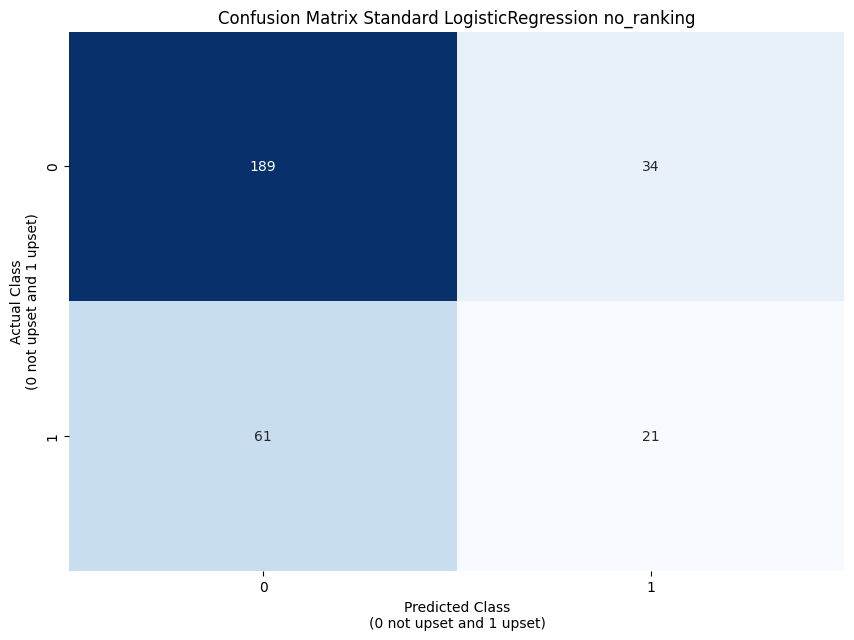

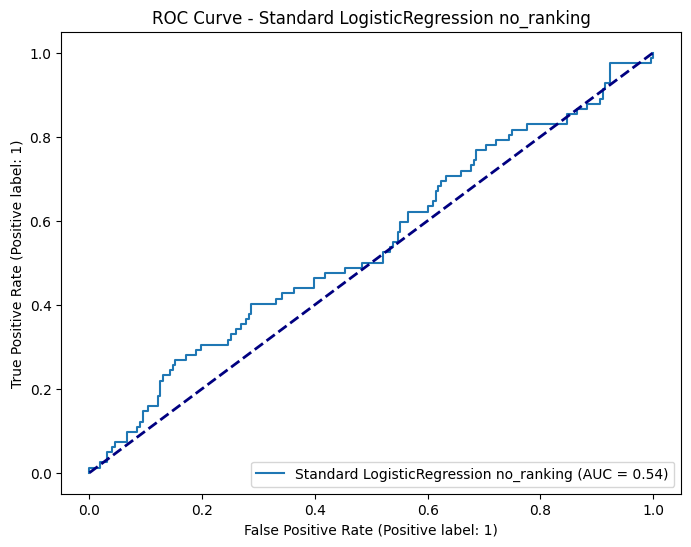

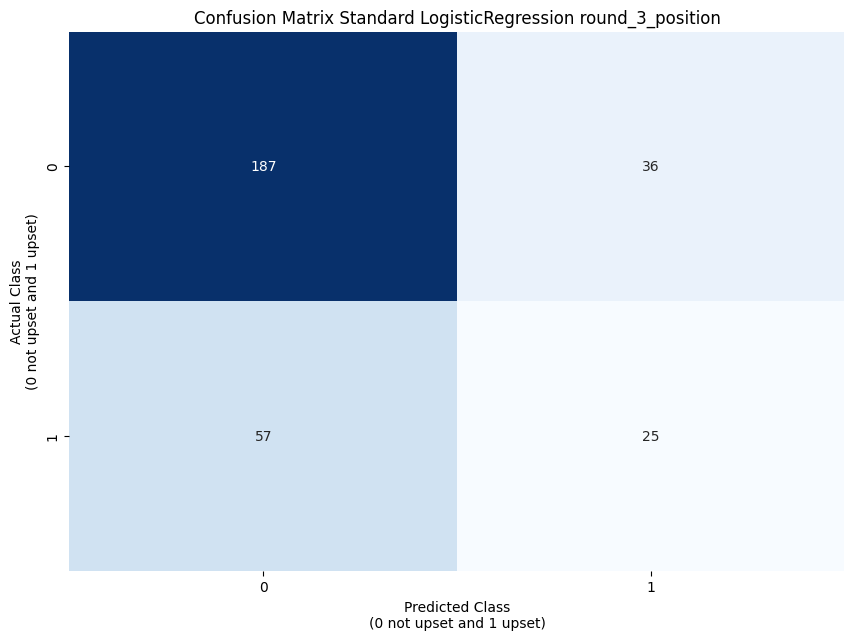

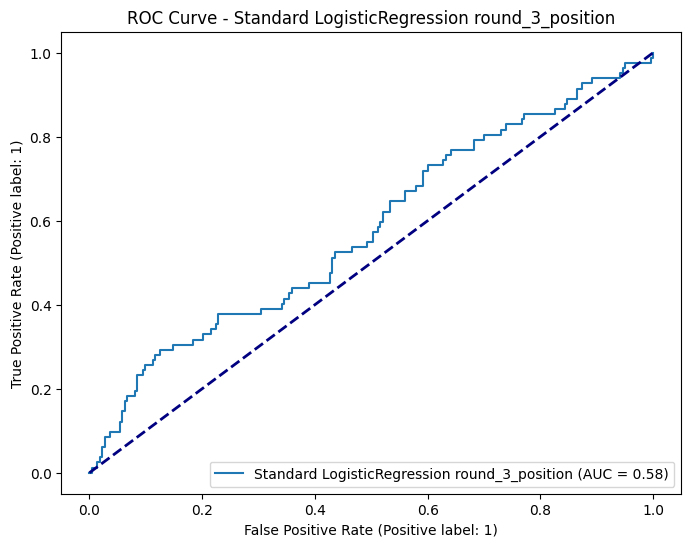

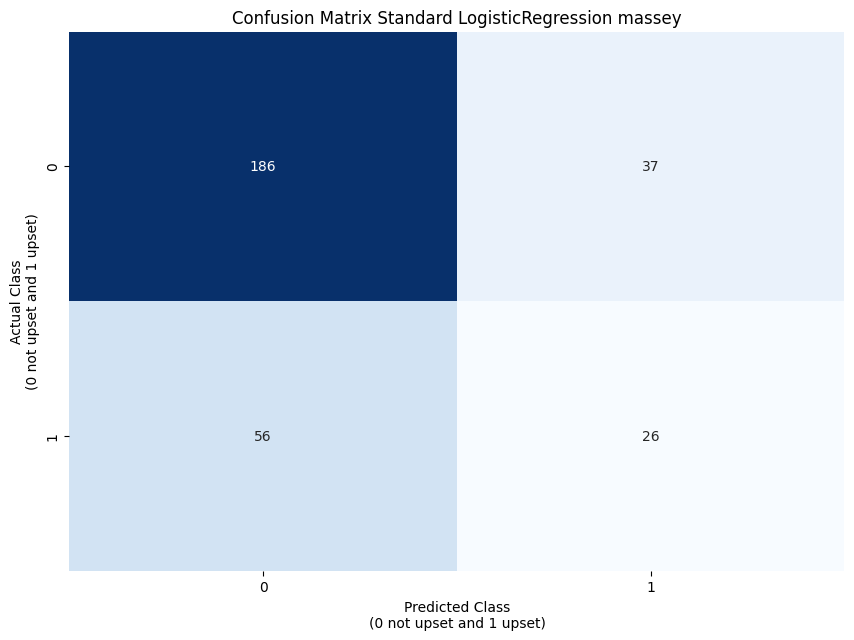

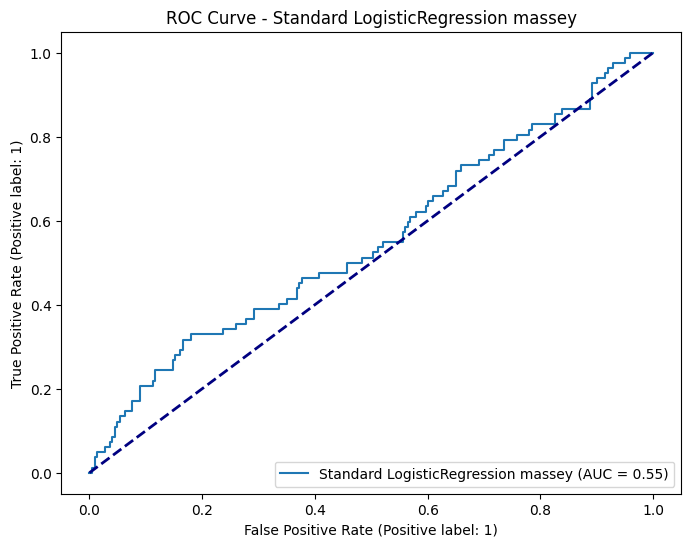

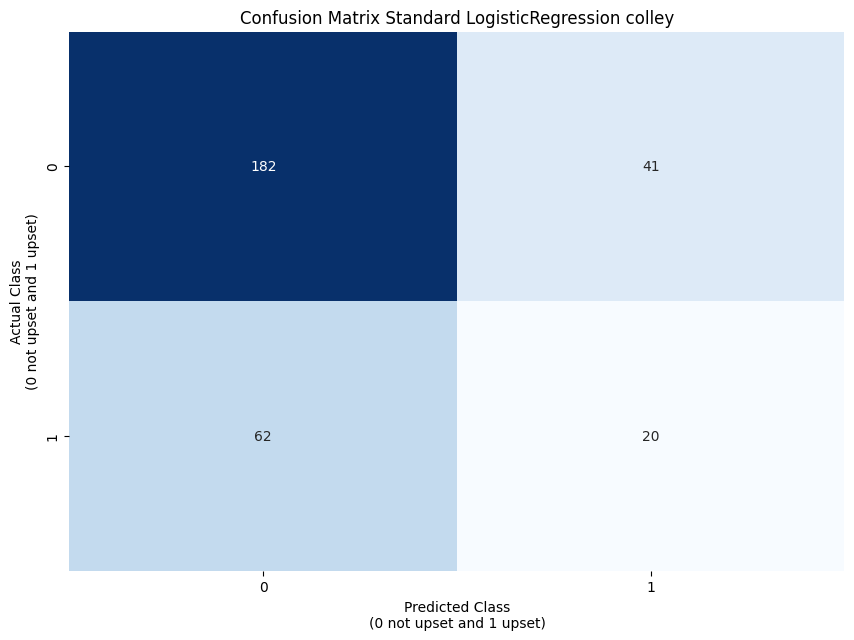

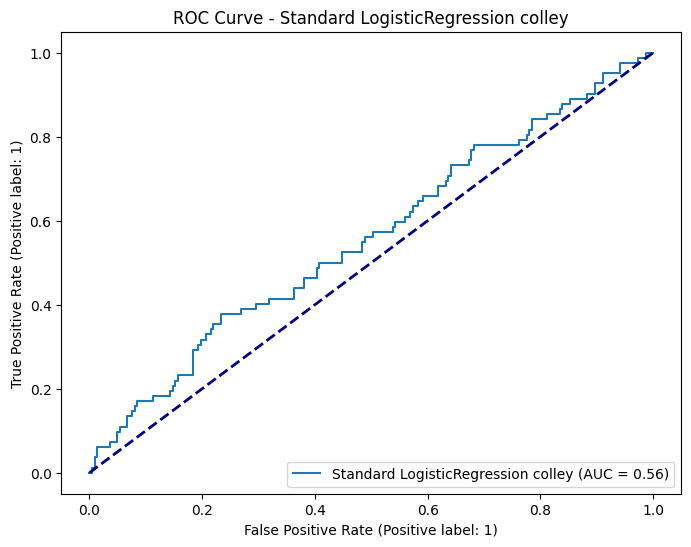

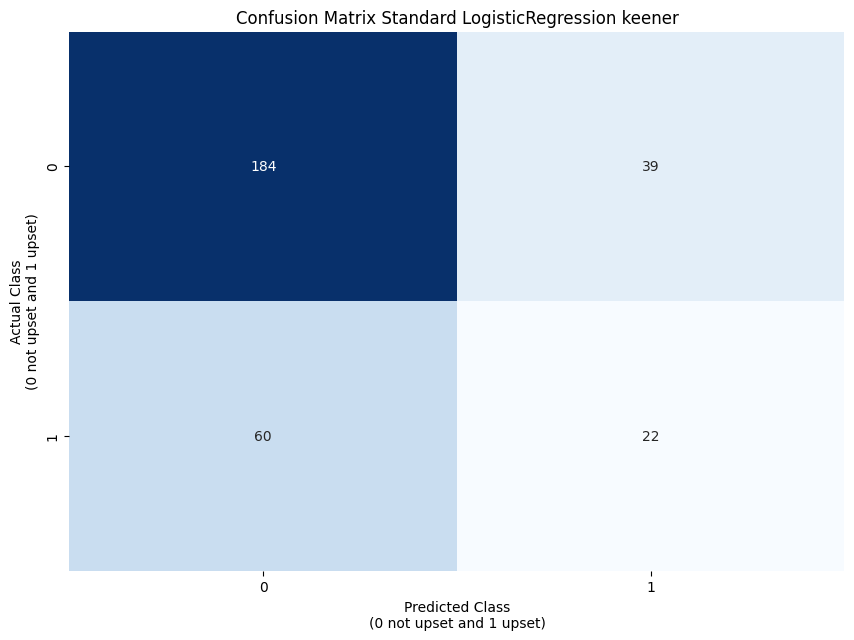

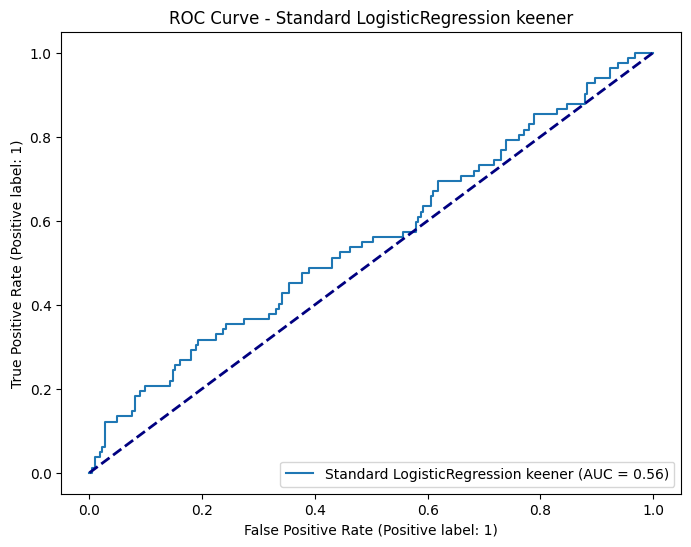

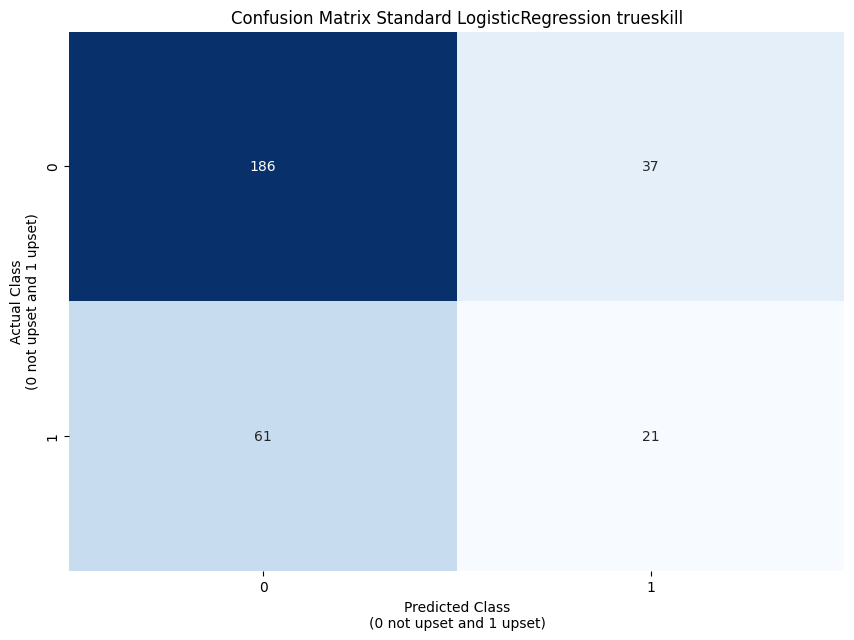

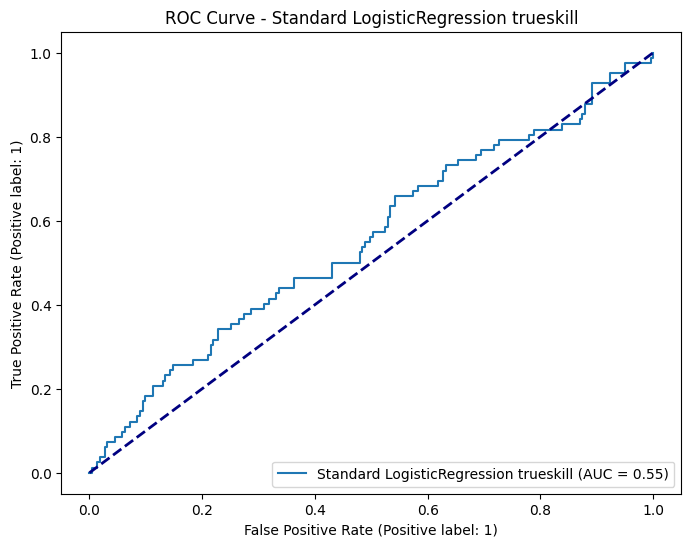

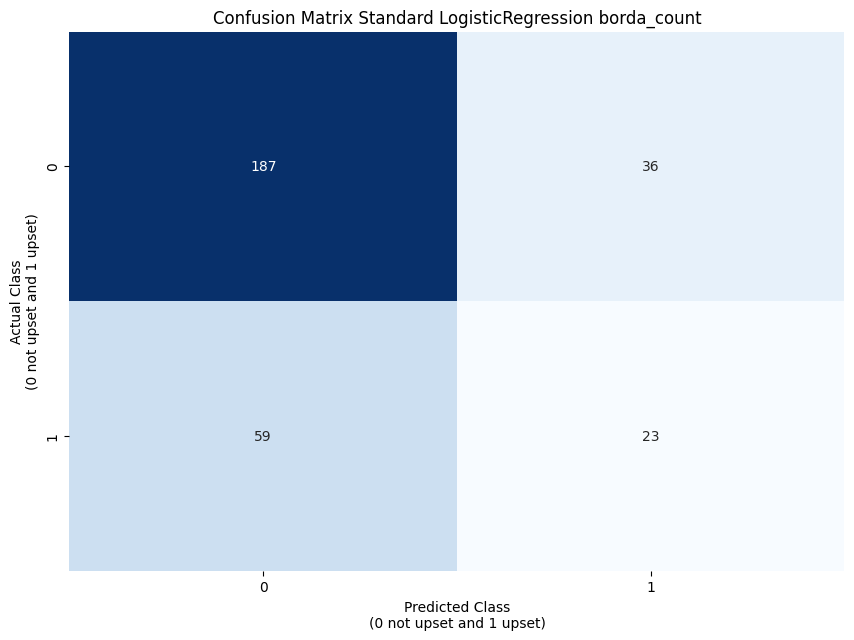

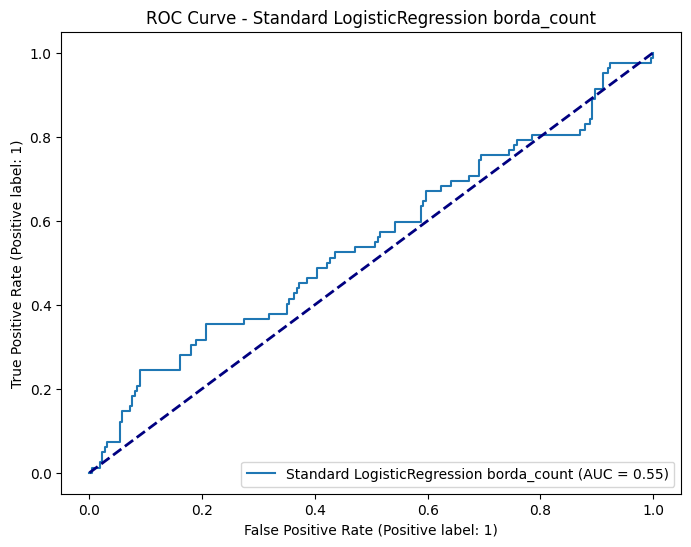

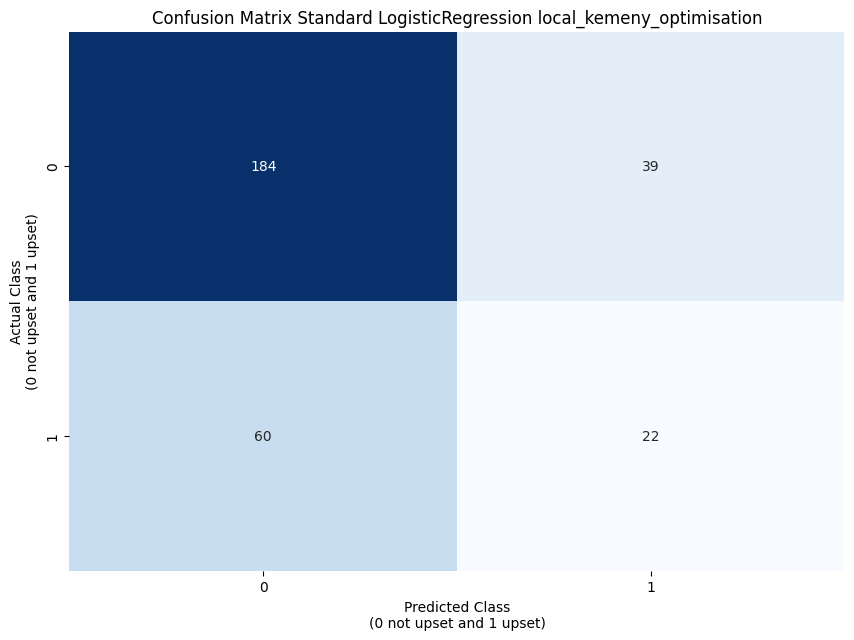

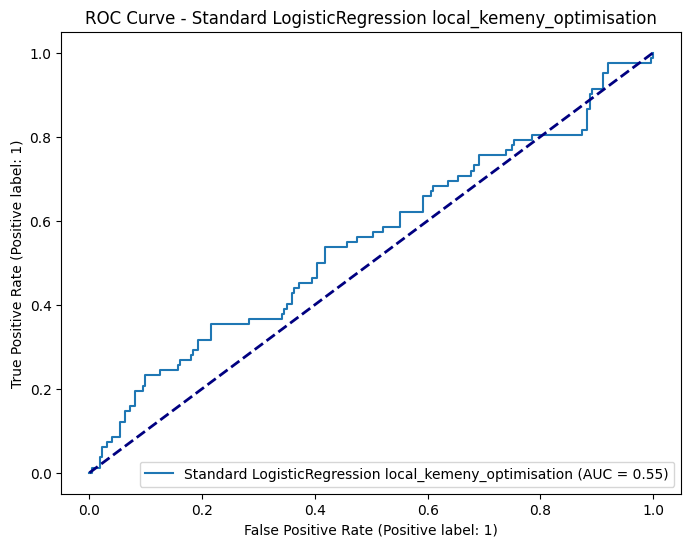

In [15]:
# Standard, no weights
model_name = "Standard LogisticRegression"
random_state= 47

# Empty df for consolidating confusion report results
all_results_df_slr = pd.DataFrame(columns=['metric_id', 'metric'])

# Fold Grid SearchCV results
fold_results_slr = []

# Define the ranking systems
ranking_systems = ['no_ranking','round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Fold Grid SearchCV results
fold_results = []

# Loop through each ranking system
for ranking in ranking_systems:
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    if ranking == 'no_ranking':
        # Use all base features without ranking
        X = fa_cup_raw_features_df[base_features]
    else:
        # Include ranking features
        current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
        X = fa_cup_raw_features_df[current_features]

    y = fa_cup_raw_features_df['target_variable']

    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    fold_recalls = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []
    all_y_pred_proba = []  # Store probabilities for ROC

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Update preprocessor
        if ranking == 'no_ranking':
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)
                ], verbose_feature_names_out=False)

        else:
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features),
                    ('rank', numeric_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
                ], verbose_feature_names_out=False)


        # Create pipeline
        pipeline = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', LogisticRegression(max_iter=1000))
          ])

        # Define the parameter grid for GridSearchCV
        param_grid = {
          'classifier__C': np.logspace(-3, 3, 7),
          'classifier__penalty': ['l1', 'l2'],
          'classifier__solver': ['liblinear', 'saga']
        }

        # Create GridSearchCV object
        grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='recall', n_jobs=-1)

        # Fit GridSearchCV
        grid_search.fit(X_train, y_train)

        # Get best model
        best_model = grid_search.best_estimator_

        # Print the best recall from GridSearchCV
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best Estimator's Recall (from GridSearchCV): {grid_search.best_score_:.3f}")

        # Convert cv_results_ to DataFrame
        #cv_results_df = pd.DataFrame(grid_search.cv_results_)
        #display(cv_results_df)

        # Make predictions
        y_pred = best_model.predict(X_val)
        y_pred_proba = best_model.predict_proba(X_val)[:, 1]

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Calculate recall
        recall = recall_score(y_val, y_pred)
        fold_recalls.append(recall)

         # Store fold results
        fold_results_slr.append({
            'Model Name Ranking': model_name_ranking,
            'Fold': fold,
            'Best Parameters (GridSearchCV)': grid_search.best_params_,
            'Best Recall (GridSearchCV)': grid_search.best_score_,
            'Validation Accuracy': accuracy,
            'Validation Recall': recall
        })

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
        all_y_pred_proba.extend(y_pred_proba)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

     # Calculate overall metrics
    mean_upset_accuracy = np.mean(fold_accuracies)
    std_upset_accuracy = np.std(fold_accuracies)


    # Create and display results using function
    results_df, cm_fig, roc_fig = create_model_results_df(all_y_true, all_y_pred, fold_accuracies,  all_y_pred_proba, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df_slr = all_results_df_slr.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df_slr)
display(fold_results_slr)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_slr.to_excel("all_slr_results.xlsx")


Standard LogisticRegression with home advantage no_ranking
Fold 1 Accuracy: 0.656
Fold 2 Accuracy: 0.705


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3 Accuracy: 0.738
Fold 4 Accuracy: 0.754


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5 Accuracy: 0.721
Average Accuracy: 0.715


,metric_id,metric,Standard LogisticRegression with home advantage no_ranking
0,1,Cross-validation Accuracy,0.715
1,2,Cross-validation Standard Deviation,0.034
2,3,Overall Accuracy,0.715
3,4,Confusion Matrix - True Negative (Class 0),215.000
4,5,Confusion Matrix - False Positive (Class 1),8.000
5,6,Confusion Matrix - False Negative (Class 0),79.000
6,7,Confusion Matrix - True Positive (Class 1),3.000
7,8,Precision (Class 0),0.731
8,9,Recall (Class 0),0.964
9,10,F1-score (Class 0),0.832


Standard LogisticRegression with home advantage round_3_position
Fold 1 Accuracy: 0.689
Fold 2 Accuracy: 0.721


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3 Accuracy: 0.738
Fold 4 Accuracy: 0.754
Fold 5 Accuracy: 0.754
Average Accuracy: 0.731


,metric_id,metric,Standard LogisticRegression with home advantage no_ranking,Standard LogisticRegression with home advantage round_3_position
0,1,Cross-validation Accuracy,0.715,0.731
1,2,Cross-validation Standard Deviation,0.034,0.025
2,3,Overall Accuracy,0.715,0.731
3,4,Confusion Matrix - True Negative (Class 0),215.000,216.000
4,5,Confusion Matrix - False Positive (Class 1),8.000,7.000
5,6,Confusion Matrix - False Negative (Class 0),79.000,75.000
6,7,Confusion Matrix - True Positive (Class 1),3.000,7.000
7,8,Precision (Class 0),0.731,0.742
8,9,Recall (Class 0),0.964,0.969
9,10,F1-score (Class 0),0.832,0.840


Standard LogisticRegression with home advantage massey
Fold 1 Accuracy: 0.656
Fold 2 Accuracy: 0.705
Fold 3 Accuracy: 0.721
Fold 4 Accuracy: 0.754
Fold 5 Accuracy: 0.738
Average Accuracy: 0.715


,metric_id,metric,Standard LogisticRegression with home advantage no_ranking,Standard LogisticRegression with home advantage round_3_position,Standard LogisticRegression with home advantage massey
0,1,Cross-validation Accuracy,0.715,0.731,0.715
1,2,Cross-validation Standard Deviation,0.034,0.025,0.034
2,3,Overall Accuracy,0.715,0.731,0.715
3,4,Confusion Matrix - True Negative (Class 0),215.000,216.000,212.000
4,5,Confusion Matrix - False Positive (Class 1),8.000,7.000,11.000
5,6,Confusion Matrix - False Negative (Class 0),79.000,75.000,76.000
6,7,Confusion Matrix - True Positive (Class 1),3.000,7.000,6.000
7,8,Precision (Class 0),0.731,0.742,0.736
8,9,Recall (Class 0),0.964,0.969,0.951
9,10,F1-score (Class 0),0.832,0.840,0.830


Standard LogisticRegression with home advantage colley
Fold 1 Accuracy: 0.672
Fold 2 Accuracy: 0.672
Fold 3 Accuracy: 0.754
Fold 4 Accuracy: 0.754
Fold 5 Accuracy: 0.738
Average Accuracy: 0.718


,metric_id,metric,Standard LogisticRegression with home advantage no_ranking,Standard LogisticRegression with home advantage round_3_position,Standard LogisticRegression with home advantage massey,Standard LogisticRegression with home advantage colley
0,1,Cross-validation Accuracy,0.715,0.731,0.715,0.718
1,2,Cross-validation Standard Deviation,0.034,0.025,0.034,0.038
2,3,Overall Accuracy,0.715,0.731,0.715,0.718
3,4,Confusion Matrix - True Negative (Class 0),215.000,216.000,212.000,212.000
4,5,Confusion Matrix - False Positive (Class 1),8.000,7.000,11.000,11.000
5,6,Confusion Matrix - False Negative (Class 0),79.000,75.000,76.000,75.000
6,7,Confusion Matrix - True Positive (Class 1),3.000,7.000,6.000,7.000
7,8,Precision (Class 0),0.731,0.742,0.736,0.739
8,9,Recall (Class 0),0.964,0.969,0.951,0.951
9,10,F1-score (Class 0),0.832,0.840,0.830,0.831


Standard LogisticRegression with home advantage keener
Fold 1 Accuracy: 0.656
Fold 2 Accuracy: 0.689
Fold 3 Accuracy: 0.754
Fold 4 Accuracy: 0.770
Fold 5 Accuracy: 0.738
Average Accuracy: 0.721


,metric_id,metric,Standard LogisticRegression with home advantage no_ranking,Standard LogisticRegression with home advantage round_3_position,Standard LogisticRegression with home advantage massey,Standard LogisticRegression with home advantage colley,Standard LogisticRegression with home advantage keener
0,1,Cross-validation Accuracy,0.715,0.731,0.715,0.718,0.721
1,2,Cross-validation Standard Deviation,0.034,0.025,0.034,0.038,0.043
2,3,Overall Accuracy,0.715,0.731,0.715,0.718,0.721
3,4,Confusion Matrix - True Negative (Class 0),215.000,216.000,212.000,212.000,211.000
4,5,Confusion Matrix - False Positive (Class 1),8.000,7.000,11.000,11.000,12.000
5,6,Confusion Matrix - False Negative (Class 0),79.000,75.000,76.000,75.000,73.000
6,7,Confusion Matrix - True Positive (Class 1),3.000,7.000,6.000,7.000,9.000
7,8,Precision (Class 0),0.731,0.742,0.736,0.739,0.743
8,9,Recall (Class 0),0.964,0.969,0.951,0.951,0.946
9,10,F1-score (Class 0),0.832,0.840,0.830,0.831,0.832


Standard LogisticRegression with home advantage trueskill
Fold 1 Accuracy: 0.672
Fold 2 Accuracy: 0.656
Fold 3 Accuracy: 0.754
Fold 4 Accuracy: 0.721
Fold 5 Accuracy: 0.738
Average Accuracy: 0.708


,metric_id,metric,Standard LogisticRegression with home advantage no_ranking,Standard LogisticRegression with home advantage round_3_position,Standard LogisticRegression with home advantage massey,Standard LogisticRegression with home advantage colley,Standard LogisticRegression with home advantage keener,Standard LogisticRegression with home advantage trueskill
0,1,Cross-validation Accuracy,0.715,0.731,0.715,0.718,0.721,0.708
1,2,Cross-validation Standard Deviation,0.034,0.025,0.034,0.038,0.043,0.038
2,3,Overall Accuracy,0.715,0.731,0.715,0.718,0.721,0.708
3,4,Confusion Matrix - True Negative (Class 0),215.000,216.000,212.000,212.000,211.000,209.000
4,5,Confusion Matrix - False Positive (Class 1),8.000,7.000,11.000,11.000,12.000,14.000
5,6,Confusion Matrix - False Negative (Class 0),79.000,75.000,76.000,75.000,73.000,75.000
6,7,Confusion Matrix - True Positive (Class 1),3.000,7.000,6.000,7.000,9.000,7.000
7,8,Precision (Class 0),0.731,0.742,0.736,0.739,0.743,0.736
8,9,Recall (Class 0),0.964,0.969,0.951,0.951,0.946,0.937
9,10,F1-score (Class 0),0.832,0.840,0.830,0.831,0.832,0.824


Standard LogisticRegression with home advantage borda_count
Fold 1 Accuracy: 0.689
Fold 2 Accuracy: 0.672
Fold 3 Accuracy: 0.738
Fold 4 Accuracy: 0.754
Fold 5 Accuracy: 0.738
Average Accuracy: 0.718


,metric_id,metric,Standard LogisticRegression with home advantage no_ranking,Standard LogisticRegression with home advantage round_3_position,Standard LogisticRegression with home advantage massey,Standard LogisticRegression with home advantage colley,Standard LogisticRegression with home advantage keener,Standard LogisticRegression with home advantage trueskill,Standard LogisticRegression with home advantage borda_count
0,1,Cross-validation Accuracy,0.715,0.731,0.715,0.718,0.721,0.708,0.718
1,2,Cross-validation Standard Deviation,0.034,0.025,0.034,0.038,0.043,0.038,0.032
2,3,Overall Accuracy,0.715,0.731,0.715,0.718,0.721,0.708,0.718
3,4,Confusion Matrix - True Negative (Class 0),215.000,216.000,212.000,212.000,211.000,209.000,211.000
4,5,Confusion Matrix - False Positive (Class 1),8.000,7.000,11.000,11.000,12.000,14.000,12.000
5,6,Confusion Matrix - False Negative (Class 0),79.000,75.000,76.000,75.000,73.000,75.000,74.000
6,7,Confusion Matrix - True Positive (Class 1),3.000,7.000,6.000,7.000,9.000,7.000,8.000
7,8,Precision (Class 0),0.731,0.742,0.736,0.739,0.743,0.736,0.740
8,9,Recall (Class 0),0.964,0.969,0.951,0.951,0.946,0.937,0.946
9,10,F1-score (Class 0),0.832,0.840,0.830,0.831,0.832,0.824,0.831


Standard LogisticRegression with home advantage local_kemeny_optimisation
Fold 1 Accuracy: 0.689
Fold 2 Accuracy: 0.689
Fold 3 Accuracy: 0.738
Fold 4 Accuracy: 0.754
Fold 5 Accuracy: 0.738
Average Accuracy: 0.721


,metric_id,metric,Standard LogisticRegression with home advantage no_ranking,Standard LogisticRegression with home advantage round_3_position,Standard LogisticRegression with home advantage massey,Standard LogisticRegression with home advantage colley,Standard LogisticRegression with home advantage keener,Standard LogisticRegression with home advantage trueskill,Standard LogisticRegression with home advantage borda_count,Standard LogisticRegression with home advantage local_kemeny_optimisation
0,1,Cross-validation Accuracy,0.715,0.731,0.715,0.718,0.721,0.708,0.718,0.721
1,2,Cross-validation Standard Deviation,0.034,0.025,0.034,0.038,0.043,0.038,0.032,0.027
2,3,Overall Accuracy,0.715,0.731,0.715,0.718,0.721,0.708,0.718,0.721
3,4,Confusion Matrix - True Negative (Class 0),215.000,216.000,212.000,212.000,211.000,209.000,211.000,212.000
4,5,Confusion Matrix - False Positive (Class 1),8.000,7.000,11.000,11.000,12.000,14.000,12.000,11.000
5,6,Confusion Matrix - False Negative (Class 0),79.000,75.000,76.000,75.000,73.000,75.000,74.000,74.000
6,7,Confusion Matrix - True Positive (Class 1),3.000,7.000,6.000,7.000,9.000,7.000,8.000,8.000
7,8,Precision (Class 0),0.731,0.742,0.736,0.739,0.743,0.736,0.740,0.741
8,9,Recall (Class 0),0.964,0.969,0.951,0.951,0.946,0.937,0.946,0.951
9,10,F1-score (Class 0),0.832,0.840,0.830,0.831,0.832,0.824,0.831,0.833


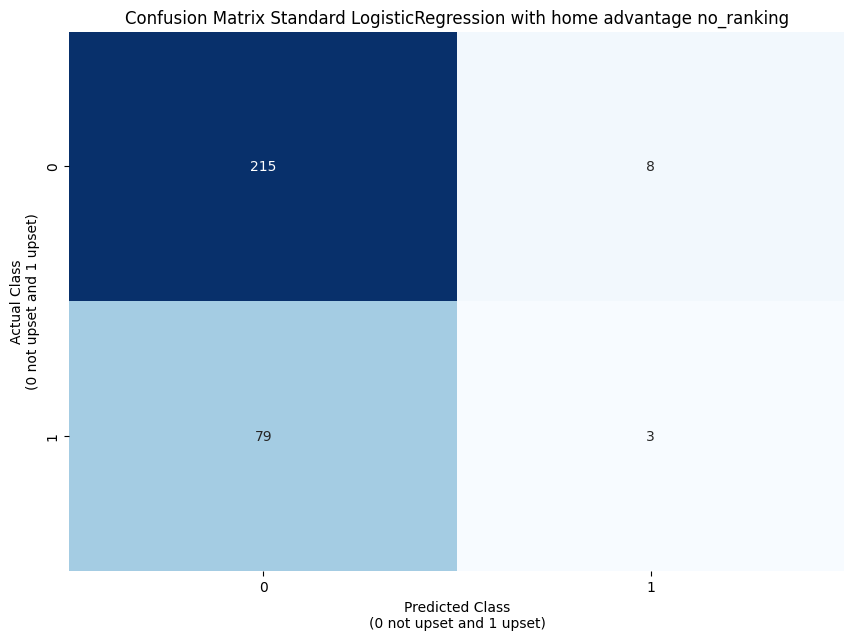

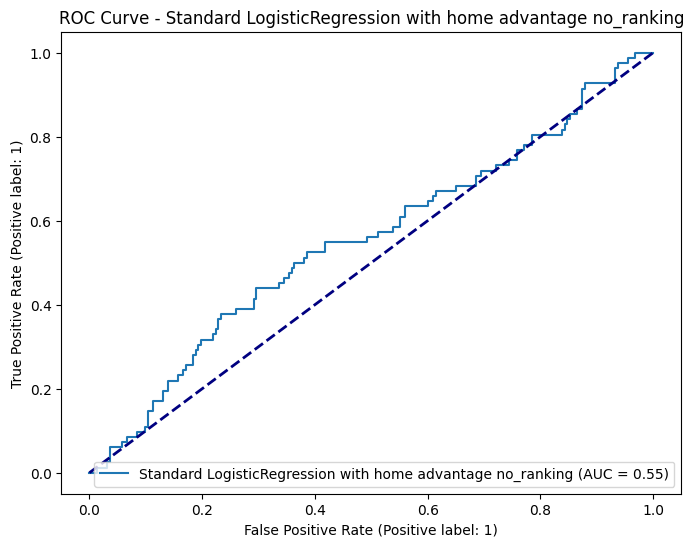

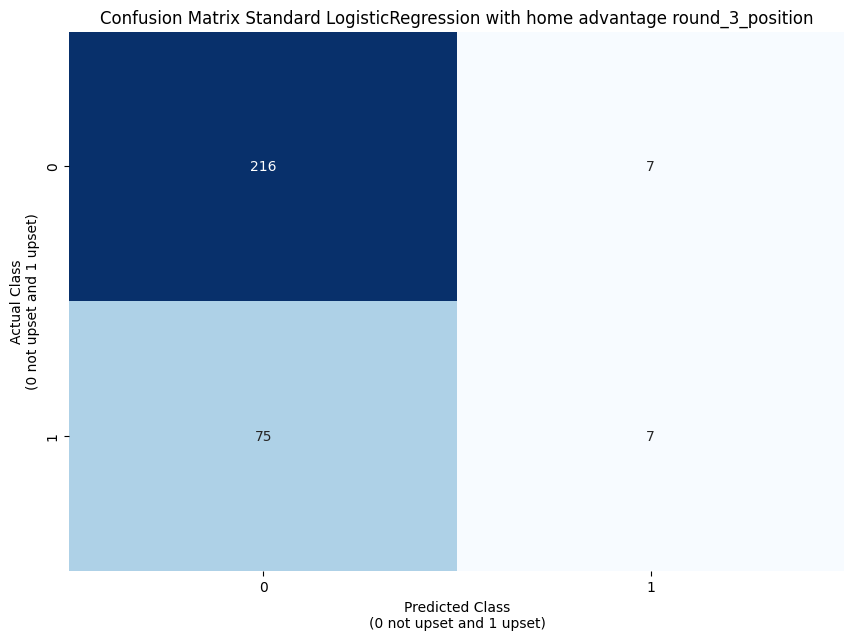

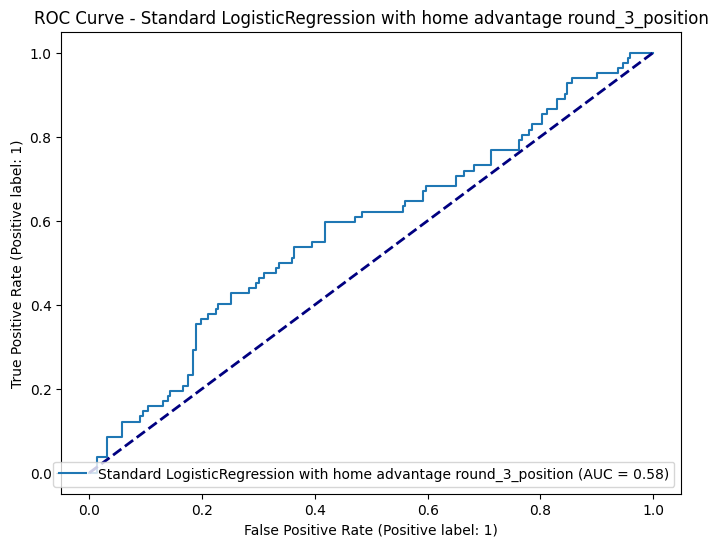

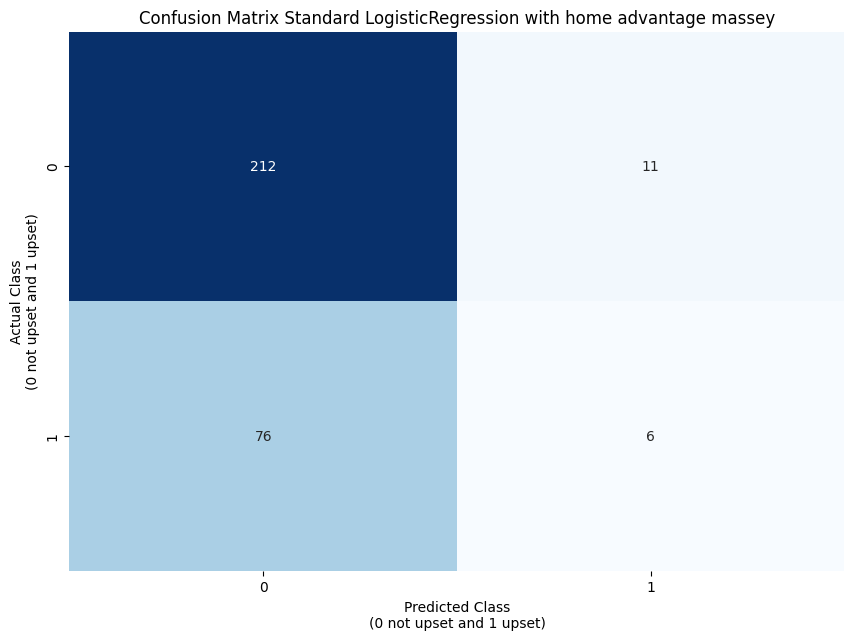

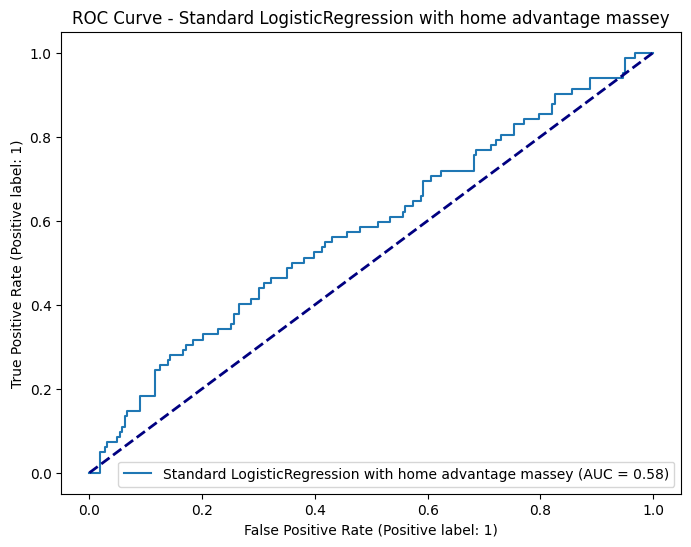

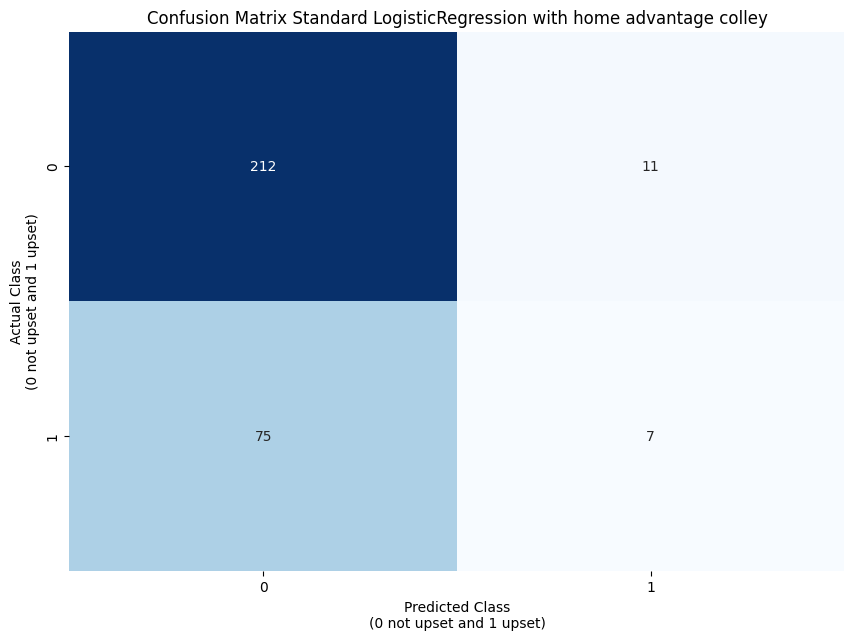

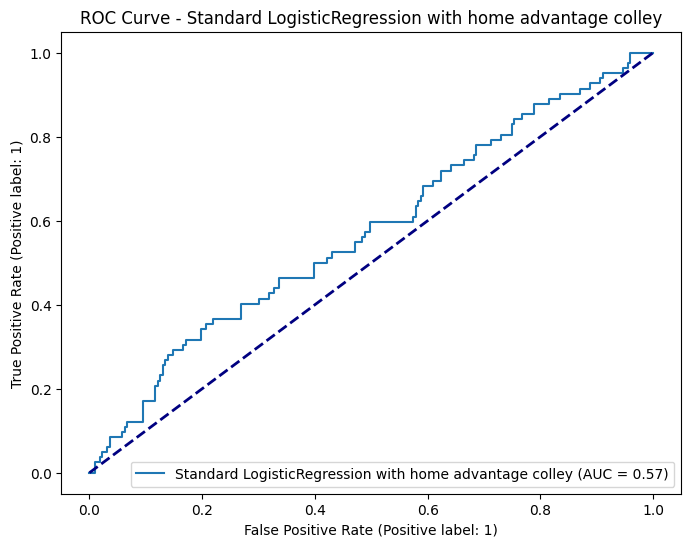

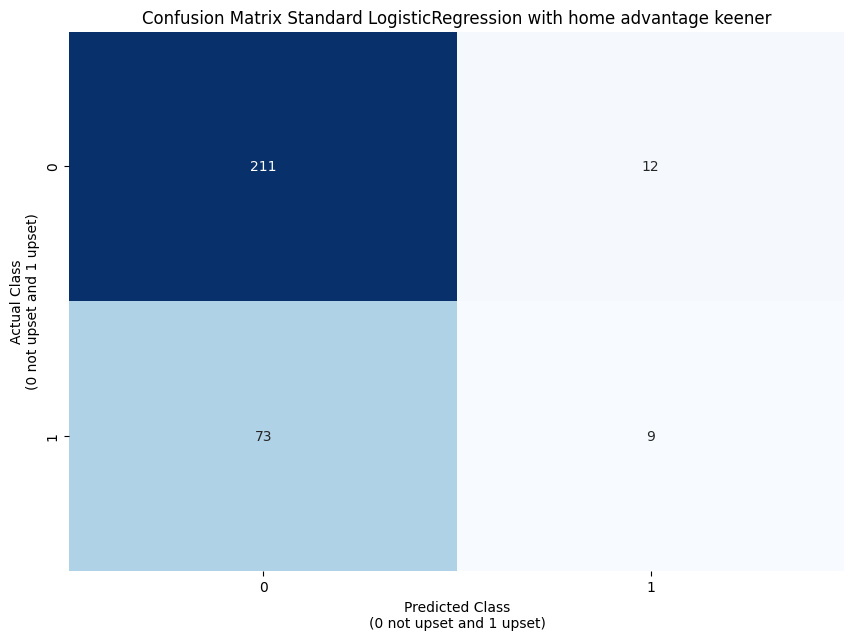

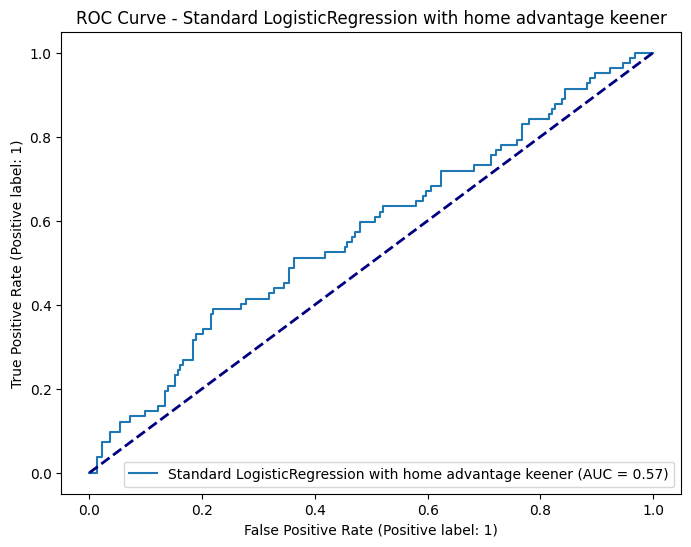

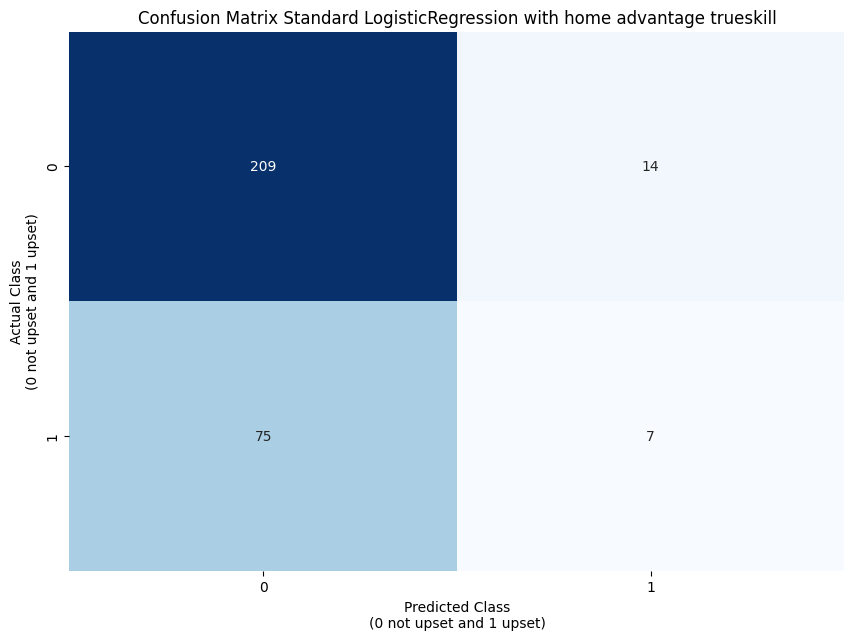

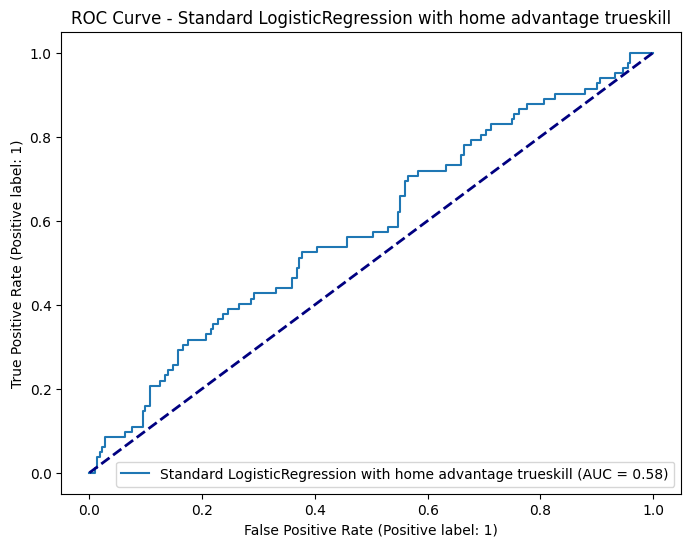

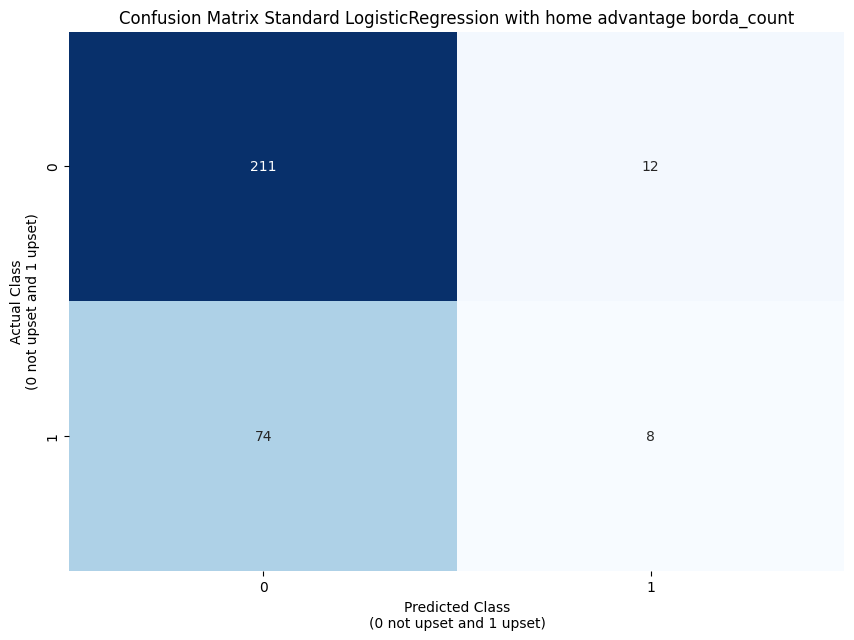

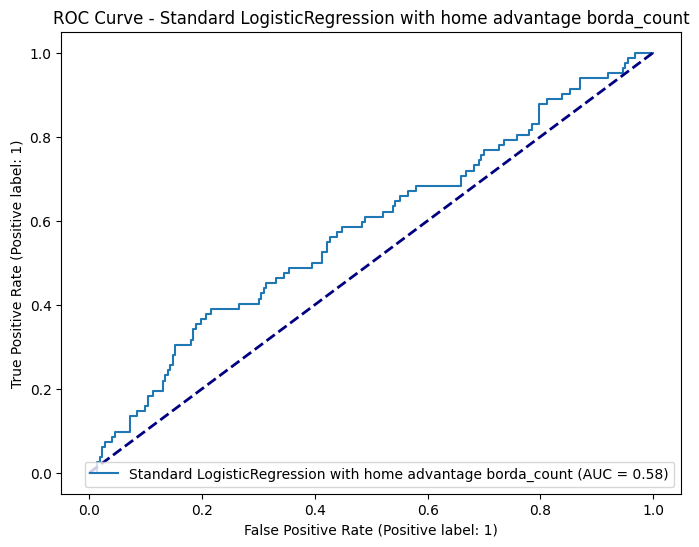

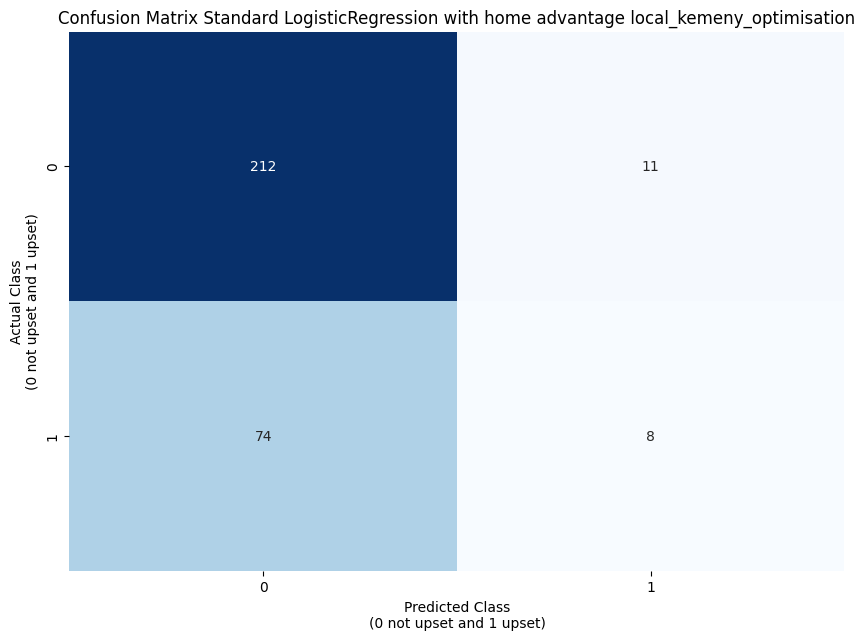

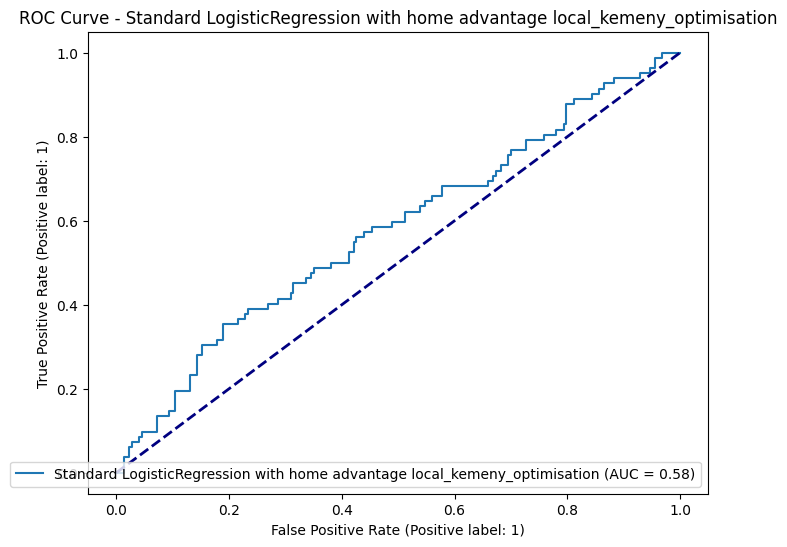

In [ ]:
# Standard, no weights with home advantage
model_name = "Standard LogisticRegression with home advantage"
random_state= 47

# Empty df for consolidating confusion report results
all_results_df_slrh = pd.DataFrame(columns=['metric_id', 'metric'])

# Define the ranking systems
ranking_systems = ['no_ranking','round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Loop through each ranking system
for ranking in ranking_systems:
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    if ranking == 'no_ranking':
        # Use all base features without ranking
        X = fa_cup_raw_features_df[base_features]
    else:
        # Prepare the feature set for the current ranking system to Include ranking features
        current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
        X = fa_cup_raw_features_df[current_features]

    y = fa_cup_raw_features_df['target_variable']

    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []
    all_y_pred_proba = []  # Store probabilities for ROC

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Add home advantage factor
        X_train, home_advantage_column = add_home_advantage(X_train)
        X_val, _ = add_home_advantage(X_val)

        # Update numeric_features to include the home advantage column
        numeric_features_with_ha = [home_advantage_column] + numeric_features

        # Update preprocessor
        if ranking == 'no_ranking':
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)
                ], verbose_feature_names_out=False)

        else:
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features),
                    ('rank', numeric_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
                ], verbose_feature_names_out=False)

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Create pipeline
        model = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', LogisticRegression(max_iter=100))
          ])

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

          # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class and ROC curve/AUC Score


        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
        all_y_pred_proba.extend(y_pred_proba)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using existing function
    results_df, cm_fig, roc_fig = create_model_results_df(all_y_true, all_y_pred, fold_accuracies,  all_y_pred_proba, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df_slrh = all_results_df_slrh.merge(results_df, on=['metric_id', 'metric'], how='outer')

    display(all_results_df_slrh)

    # Change default ouput directory
    os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
    # Save ranks to excel
    all_results_df_slrh.to_excel("all_slrh_results.xlsx")

In [ ]:
# Weighted Logistc Regression
model_name = "Weighted LogisticRegression"
random_state= 47

# Function to calculate weights
def calculate_weights(y):
    class_counts = y.value_counts()
    total_samples = len(y)
    return {class_label: int(round((1 - (count / total_samples)) * 100))
            for class_label, count in class_counts.items()}

# Empty df for consolidating confusion report results
all_results_df_wlr = pd.DataFrame(columns=['metric_id', 'metric'])

# Define the ranking systems
ranking_systems = ['no_ranking','round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]


# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Loop through each ranking system
for ranking in ranking_systems:
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    if ranking == 'no_ranking':
        # Use all base features without ranking
        X = fa_cup_raw_features_df[base_features]
    else:
        # Prepare the feature set for the current ranking system to Include ranking features
        current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
        X = fa_cup_raw_features_df[current_features]

    y = fa_cup_raw_features_df['target_variable']

    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []
    all_y_pred_proba = []  # Store probabilities for ROC

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Update preprocessor with current features including home advantage
        if ranking == 'no_ranking':
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)
                ], verbose_feature_names_out=False)

        else:
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features),
                    ('rank', numeric_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
                ], verbose_feature_names_out=False)

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Calculate weights using only training data
        weights = calculate_weights(y_train)

        # Create pipeline
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(class_weight=weights,max_iter=1000))
        ])


        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class and ROC curve/AUC Score

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
        all_y_pred_proba.extend(y_pred_proba)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using existing function
    results_df, cm_fig, roc_fig = create_model_results_df(all_y_true, all_y_pred, fold_accuracies,  all_y_pred_proba, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df_wlr = all_results_df_wlr.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df_wlr)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_wlr.to_excel("all_wlr_results.xlsx")


In [ ]:
# Weighted Logistc Regression with home advatange
model_name = "Weighted LogisticRegression with home advantage"
random_state= 47

# Function to calculate weights
def calculate_weights(y):
    class_counts = y.value_counts()
    total_samples = len(y)
    return {class_label: int(round((1 - (count / total_samples)) * 100))
            for class_label, count in class_counts.items()}

# Empty df for consolidating confusion report results
all_results_df_wlrh = pd.DataFrame(columns=['metric_id', 'metric'])

# Define the ranking systems
ranking_systems = ['no_ranking','round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]


# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Loop through each ranking system
for ranking in ranking_systems:
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    if ranking == 'no_ranking':
        # Use all base features without ranking
        X = fa_cup_raw_features_df[base_features]
    else:
        # Prepare the feature set for the current ranking system to Include ranking features
        current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
        X = fa_cup_raw_features_df[current_features]

    y = fa_cup_raw_features_df['target_variable']

    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []
    all_y_pred_proba = []  # Store probabilities for ROC

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]


        # Add home advantage factor
        X_train, home_advantage_column = add_home_advantage(X_train)
        X_val, _ = add_home_advantage(X_val)

        # Update numeric_features to include the home advantage column
        numeric_features_with_ha = [home_advantage_column] + numeric_features

        # Update preprocessor with current features including home advantage
        if ranking == 'no_ranking':
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)
                ], verbose_feature_names_out=False)

        else:
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features),
                    ('rank', numeric_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
                ], verbose_feature_names_out=False)

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Calculate weights using only training data
        weights = calculate_weights(y_train)

        # Create pipeline
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(class_weight=weights,max_iter=1000))
        ])


        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class and ROC curve/AUC Score

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
        all_y_pred_proba.extend(y_pred_proba)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using existing function
    results_df, cm_fig, roc_fig = create_model_results_df(all_y_true, all_y_pred, fold_accuracies,  all_y_pred_proba, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df_wlrh = all_results_df_wlrh.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df_wlrh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_wlrh.to_excel("all_wlrh_results.xlsx")


,metric_id,metric,Weighted LogisticRegression with home advantage no_ranking,Weighted LogisticRegression with home advantage round_3_position,Weighted LogisticRegression with home advantage massey,Weighted LogisticRegression with home advantage colley,Weighted LogisticRegression with home advantage keener,Weighted LogisticRegression with home advantage trueskill,Weighted LogisticRegression with home advantage borda_count,Weighted LogisticRegression with home advantage local_kemeny_optimisation
0,1,Cross-validation Accuracy,0.544,0.564,0.564,0.561,0.554,0.577,0.577,0.570
1,2,Cross-validation Standard Deviation,0.096,0.085,0.082,0.084,0.078,0.079,0.091,0.100
2,3,Overall Accuracy,0.544,0.564,0.564,0.561,0.554,0.577,0.577,0.570
3,4,Confusion Matrix - True Negative (Class 0),128.000,132.000,134.000,134.000,131.000,138.000,138.000,137.000
4,5,Confusion Matrix - False Positive (Class 1),95.000,91.000,89.000,89.000,92.000,85.000,85.000,86.000
5,6,Confusion Matrix - False Negative (Class 0),44.000,42.000,44.000,45.000,44.000,44.000,44.000,45.000
6,7,Confusion Matrix - True Positive (Class 1),38.000,40.000,38.000,37.000,38.000,38.000,38.000,37.000
7,8,Precision (Class 0),0.744,0.759,0.753,0.749,0.749,0.758,0.758,0.753
8,9,Recall (Class 0),0.574,0.592,0.601,0.601,0.587,0.619,0.619,0.614
9,10,F1-score (Class 0),0.648,0.665,0.668,0.667,0.658,0.681,0.681,0.677


MLP Classifier Neural Network no_ranking
Fold 1 Accuracy: 0.984
Fold 2 Accuracy: 0.951
Fold 3 Accuracy: 0.934
Fold 4 Accuracy: 0.984
Fold 5 Accuracy: 0.852
Average Accuracy: 0.941
MLP Classifier Neural Network round_3_position
Fold 1 Accuracy: 1.000
Fold 2 Accuracy: 0.967
Fold 3 Accuracy: 0.951
Fold 4 Accuracy: 0.967
Fold 5 Accuracy: 0.902
Average Accuracy: 0.957
MLP Classifier Neural Network massey
Fold 1 Accuracy: 1.000
Fold 2 Accuracy: 0.967
Fold 3 Accuracy: 0.951
Fold 4 Accuracy: 0.934
Fold 5 Accuracy: 0.836
Average Accuracy: 0.938
MLP Classifier Neural Network colley
Fold 1 Accuracy: 0.984
Fold 2 Accuracy: 0.984
Fold 3 Accuracy: 0.934
Fold 4 Accuracy: 0.967
Fold 5 Accuracy: 0.902
Average Accuracy: 0.954
MLP Classifier Neural Network keener
Fold 1 Accuracy: 0.984
Fold 2 Accuracy: 0.967
Fold 3 Accuracy: 0.934
Fold 4 Accuracy: 0.967
Fold 5 Accuracy: 0.836
Average Accuracy: 0.938
MLP Classifier Neural Network trueskill
Fold 1 Accuracy: 0.984
Fold 2 Accuracy: 0.984
Fold 3 Accuracy: 0.9

,metric_id,metric,MLP Classifier Neural Network no_ranking,MLP Classifier Neural Network round_3_position,MLP Classifier Neural Network massey,MLP Classifier Neural Network colley,MLP Classifier Neural Network keener,MLP Classifier Neural Network trueskill,MLP Classifier Neural Network borda_count,MLP Classifier Neural Network local_kemeny_optimisation
0,1,Cross-validation Accuracy,0.941,0.957,0.938,0.954,0.938,0.951,0.954,0.944
1,2,Cross-validation Standard Deviation,0.048,0.032,0.055,0.032,0.053,0.031,0.022,0.030
2,3,Overall Accuracy,0.941,0.957,0.938,0.954,0.938,0.951,0.954,0.944
3,4,Confusion Matrix - True Negative (Class 0),220.000,219.000,220.000,219.000,218.000,219.000,220.000,219.000
4,5,Confusion Matrix - False Positive (Class 1),3.000,4.000,3.000,4.000,5.000,4.000,3.000,4.000
5,6,Confusion Matrix - False Negative (Class 0),15.000,9.000,16.000,10.000,14.000,11.000,11.000,13.000
6,7,Confusion Matrix - True Positive (Class 1),67.000,73.000,66.000,72.000,68.000,71.000,71.000,69.000
7,8,Precision (Class 0),0.936,0.961,0.932,0.956,0.940,0.952,0.952,0.944
8,9,Recall (Class 0),0.987,0.982,0.987,0.982,0.978,0.982,0.987,0.982
9,10,F1-score (Class 0),0.961,0.971,0.959,0.969,0.958,0.967,0.969,0.963


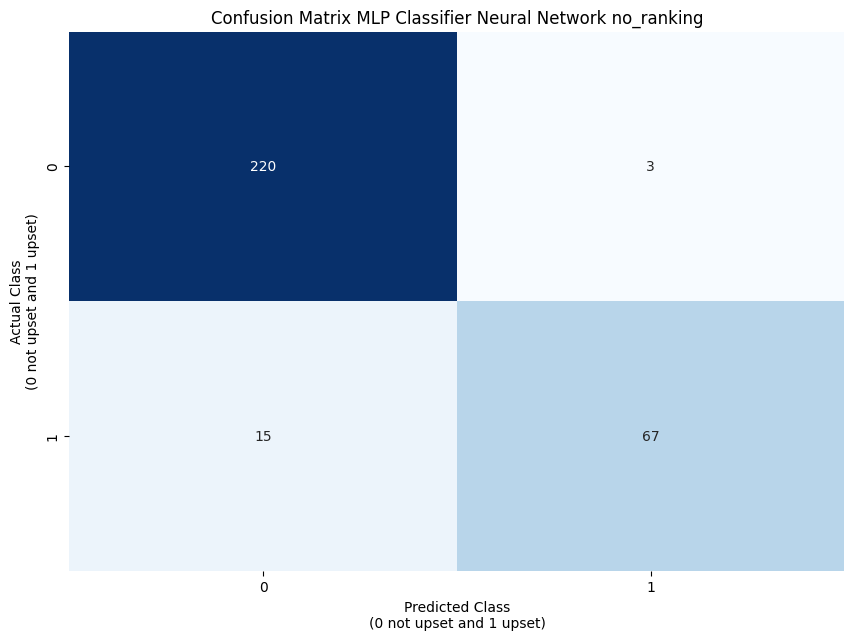

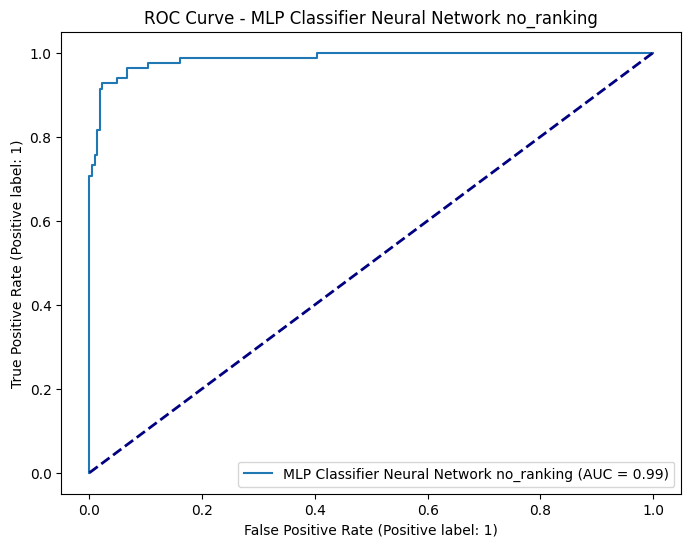

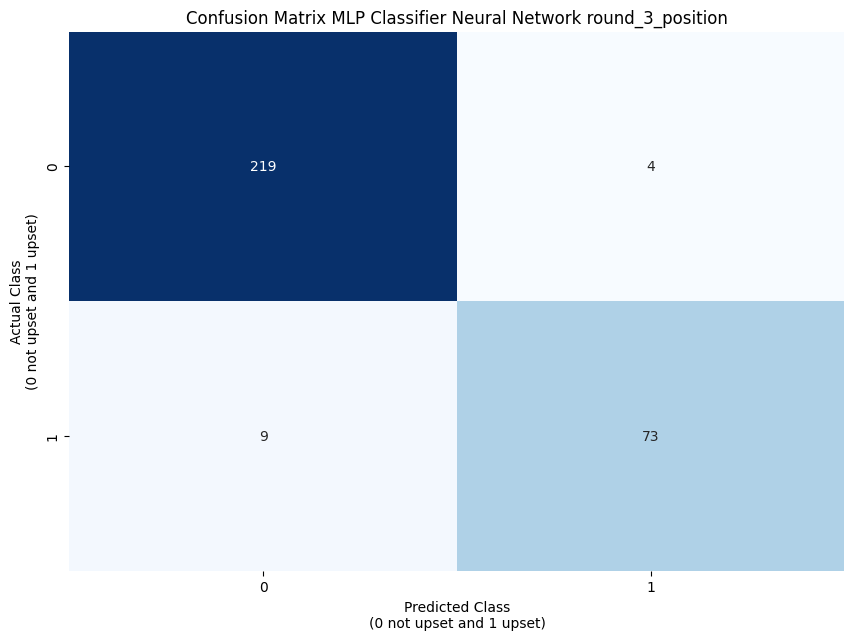

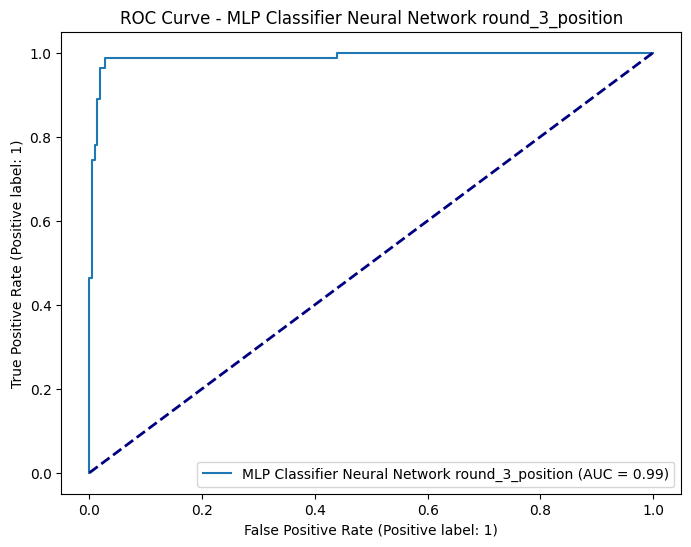

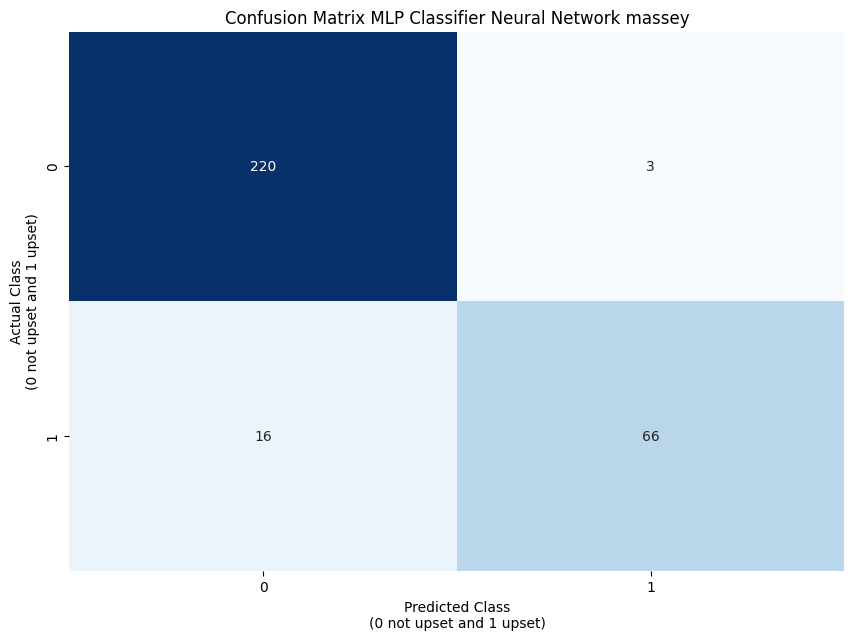

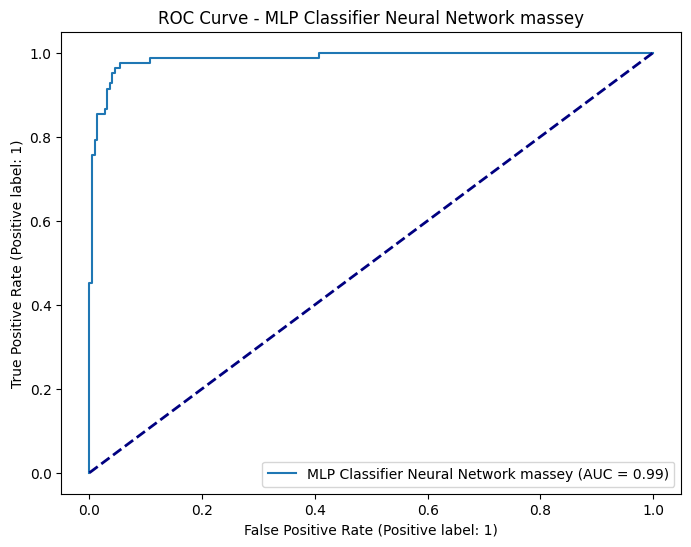

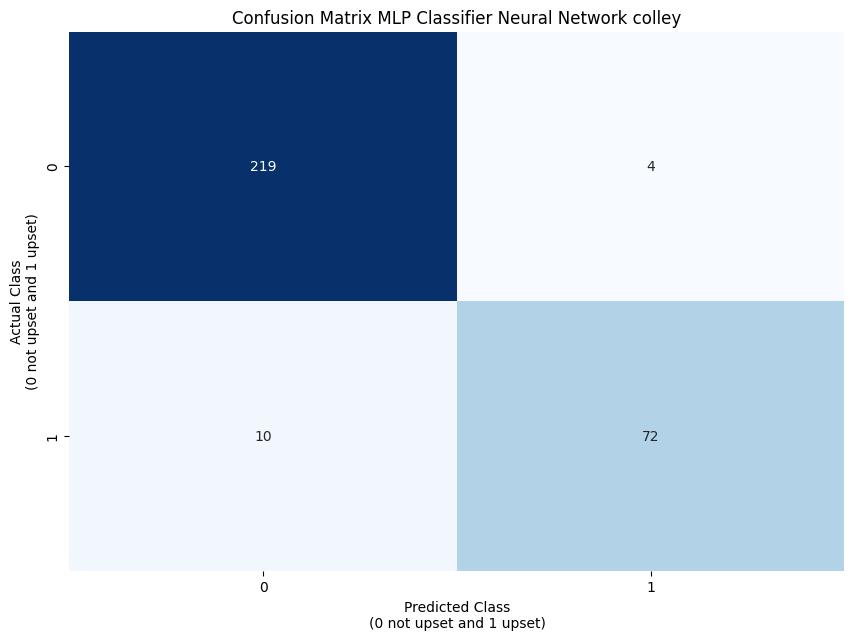

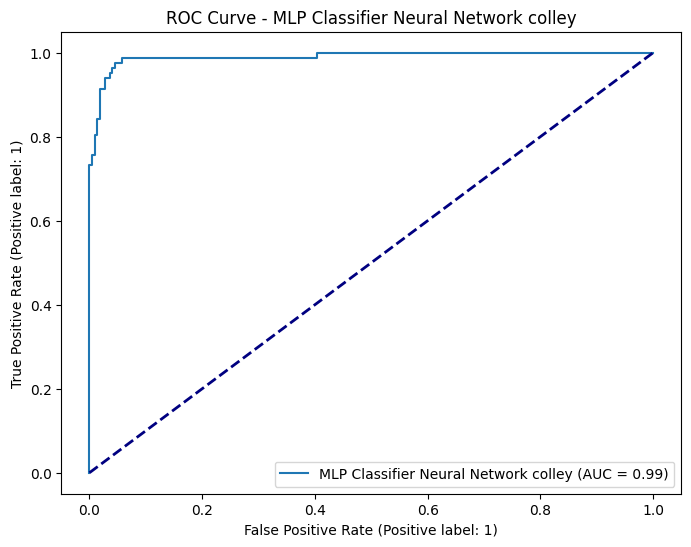

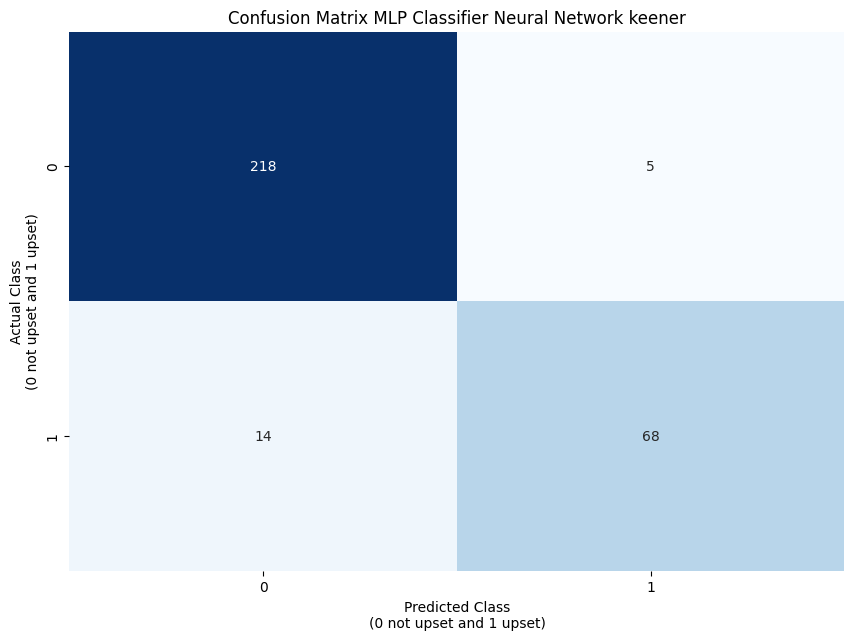

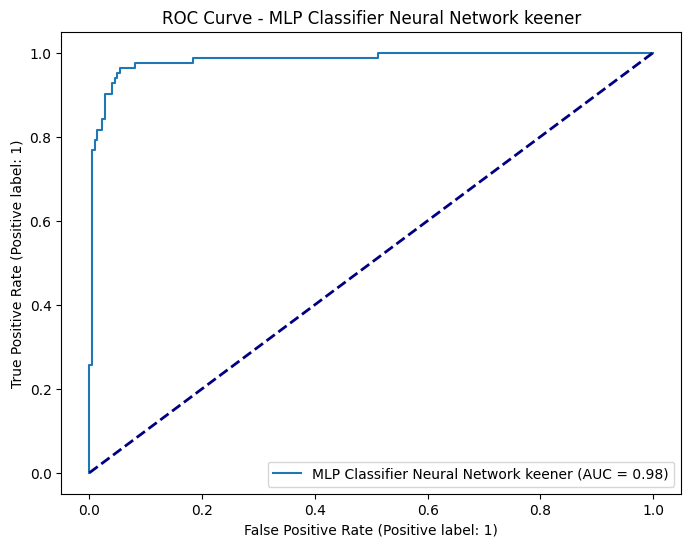

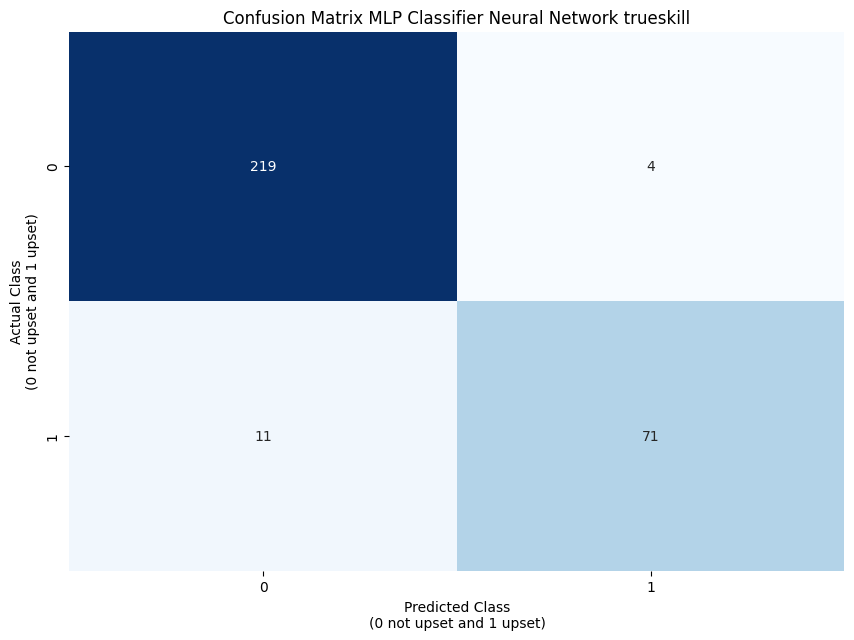

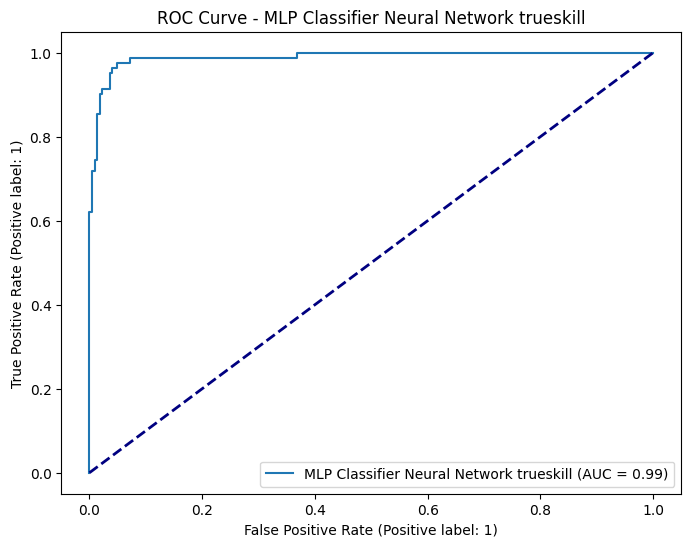

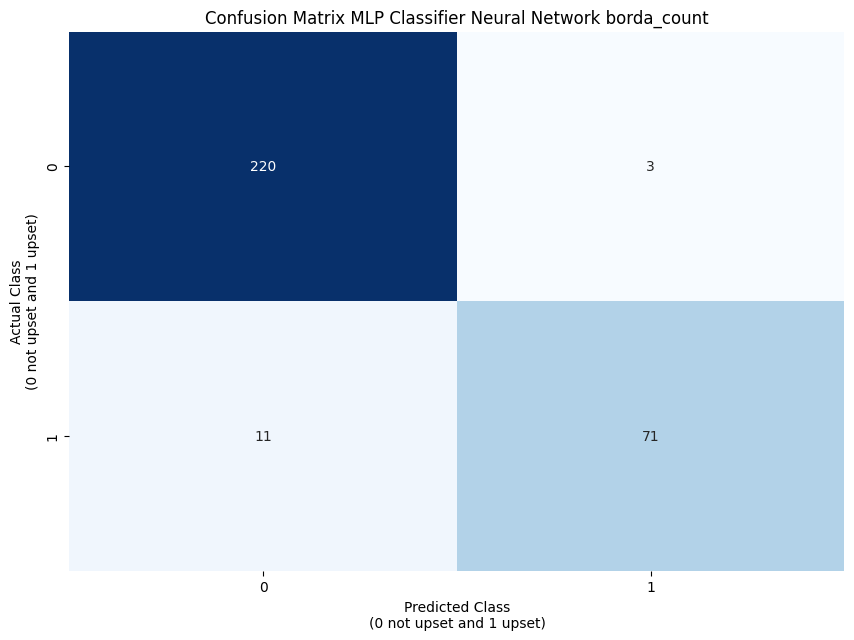

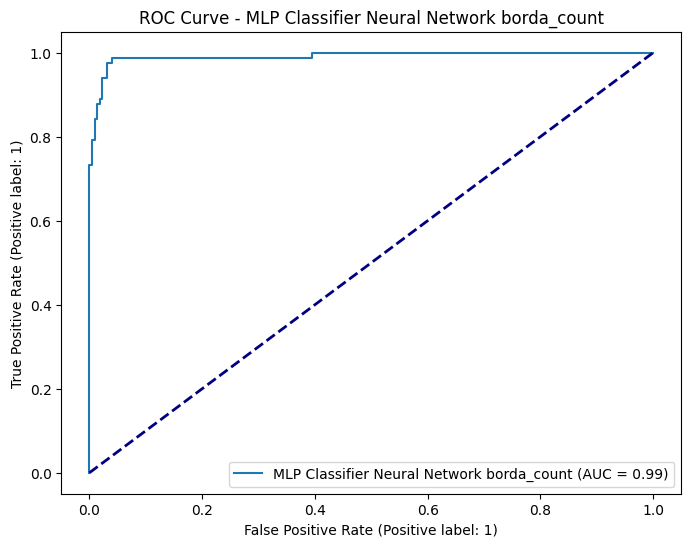

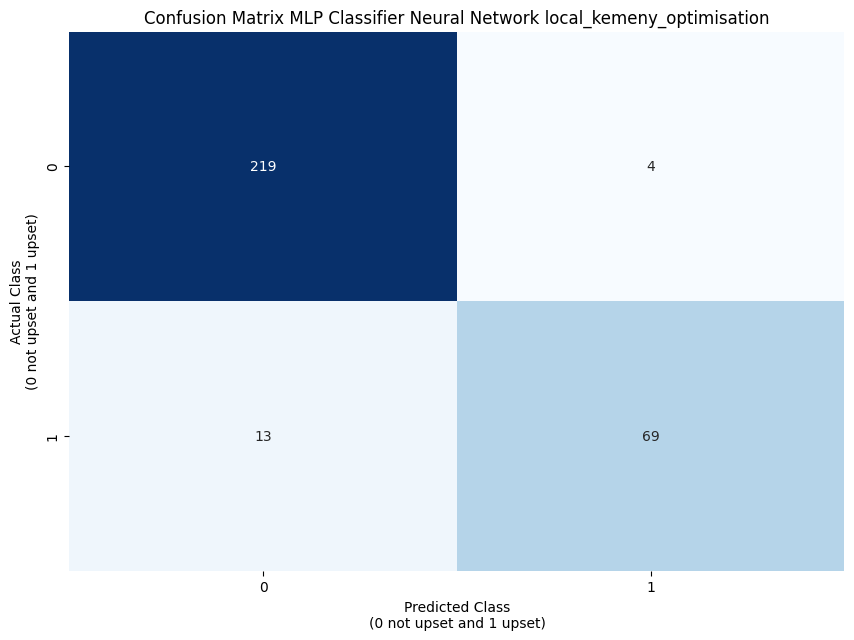

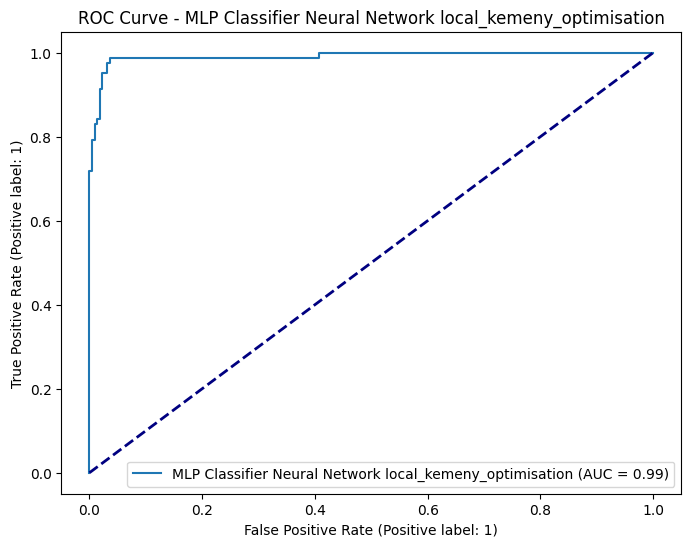

In [ ]:
# MCP Neural Network
model_name = "MLP Classifier Neural Network"
random_state= 47

# Empty df for consolidating confusion report results
all_results_df_nn = pd.DataFrame(columns=['metric_id', 'metric'])

# Define the ranking systems
ranking_systems = ['no_ranking','round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]


# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Loop through each ranking system
for ranking in ranking_systems:
    #print(f"\nRunning model for {ranking} ranking system")
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    if ranking == 'no_ranking':
        # Use all base features without ranking
        X = fa_cup_raw_features_df[base_features]
    else:
        # Prepare the feature set for the current ranking system to Include ranking features
        current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
        X = fa_cup_raw_features_df[current_features]

    y = fa_cup_raw_features_df['target_variable']

    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []
    all_y_pred_proba = []  # Store probabilities for ROC

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Update preprocessor with current features including home advantage
        if ranking == 'no_ranking':
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)
                ], verbose_feature_names_out=False)

        else:
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features),
                    ('rank', numeric_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
                ], verbose_feature_names_out=False)

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Create pipeline
        model = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', MLPClassifier(hidden_layer_sizes=(10), max_iter=10000, random_state=random_state))
          ])

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class and ROC curve/AUC Score

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
        all_y_pred_proba.extend(y_pred_proba)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using existing function
    results_df, cm_fig, roc_fig = create_model_results_df(all_y_true, all_y_pred, fold_accuracies,  all_y_pred_proba, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df_nn = all_results_df_nn.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df_nn)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_nn.to_excel("all_nn_results.xlsx")

MLP Classifier Neural Network with home advantage no_ranking
Fold 1 Accuracy: 0.984
Fold 2 Accuracy: 0.951
Fold 3 Accuracy: 0.934
Fold 4 Accuracy: 0.984
Fold 5 Accuracy: 0.852
Average Accuracy: 0.941
MLP Classifier Neural Network with home advantage round_3_position
Fold 1 Accuracy: 1.000
Fold 2 Accuracy: 0.967
Fold 3 Accuracy: 0.951
Fold 4 Accuracy: 0.967
Fold 5 Accuracy: 0.902
Average Accuracy: 0.957
MLP Classifier Neural Network with home advantage massey
Fold 1 Accuracy: 1.000
Fold 2 Accuracy: 0.967
Fold 3 Accuracy: 0.951
Fold 4 Accuracy: 0.934
Fold 5 Accuracy: 0.836
Average Accuracy: 0.938
MLP Classifier Neural Network with home advantage colley
Fold 1 Accuracy: 0.984
Fold 2 Accuracy: 0.984
Fold 3 Accuracy: 0.934
Fold 4 Accuracy: 0.967
Fold 5 Accuracy: 0.902
Average Accuracy: 0.954
MLP Classifier Neural Network with home advantage keener
Fold 1 Accuracy: 0.984
Fold 2 Accuracy: 0.967
Fold 3 Accuracy: 0.934
Fold 4 Accuracy: 0.967
Fold 5 Accuracy: 0.836
Average Accuracy: 0.938
MLP Cl

,metric_id,metric,MLP Classifier Neural Network with home advantage no_ranking,MLP Classifier Neural Network with home advantage round_3_position,MLP Classifier Neural Network with home advantage massey,MLP Classifier Neural Network with home advantage colley,MLP Classifier Neural Network with home advantage keener,MLP Classifier Neural Network with home advantage trueskill,MLP Classifier Neural Network with home advantage borda_count,MLP Classifier Neural Network with home advantage local_kemeny_optimisation
0,1,Cross-validation Accuracy,0.941,0.957,0.938,0.954,0.938,0.951,0.954,0.944
1,2,Cross-validation Standard Deviation,0.048,0.032,0.055,0.032,0.053,0.031,0.022,0.030
2,3,Overall Accuracy,0.941,0.957,0.938,0.954,0.938,0.951,0.954,0.944
3,4,Confusion Matrix - True Negative (Class 0),220.000,219.000,220.000,219.000,218.000,219.000,220.000,219.000
4,5,Confusion Matrix - False Positive (Class 1),3.000,4.000,3.000,4.000,5.000,4.000,3.000,4.000
5,6,Confusion Matrix - False Negative (Class 0),15.000,9.000,16.000,10.000,14.000,11.000,11.000,13.000
6,7,Confusion Matrix - True Positive (Class 1),67.000,73.000,66.000,72.000,68.000,71.000,71.000,69.000
7,8,Precision (Class 0),0.936,0.961,0.932,0.956,0.940,0.952,0.952,0.944
8,9,Recall (Class 0),0.987,0.982,0.987,0.982,0.978,0.982,0.987,0.982
9,10,F1-score (Class 0),0.961,0.971,0.959,0.969,0.958,0.967,0.969,0.963


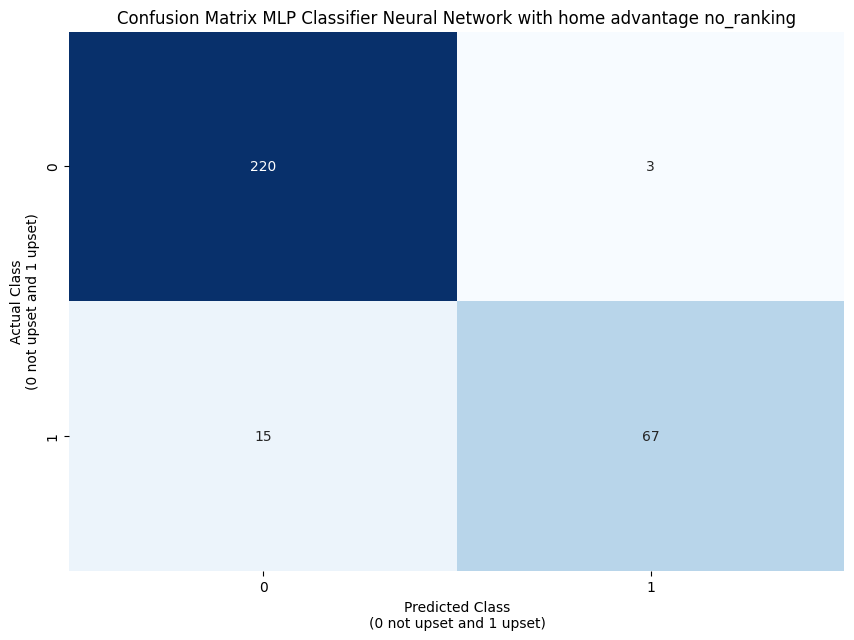

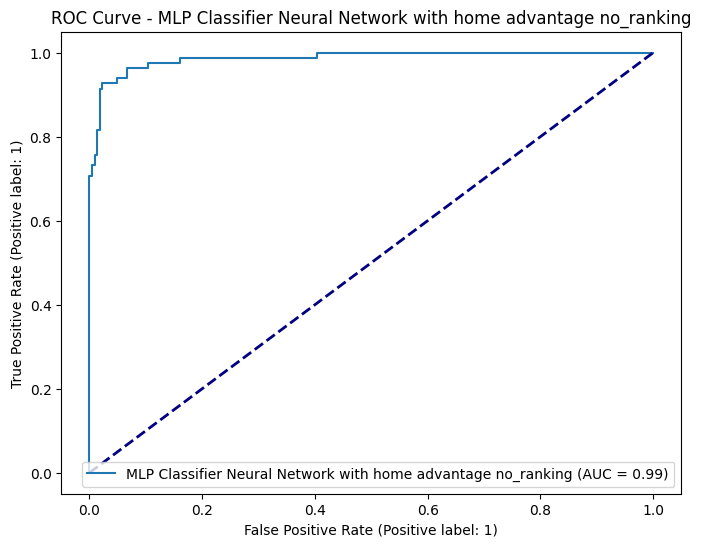

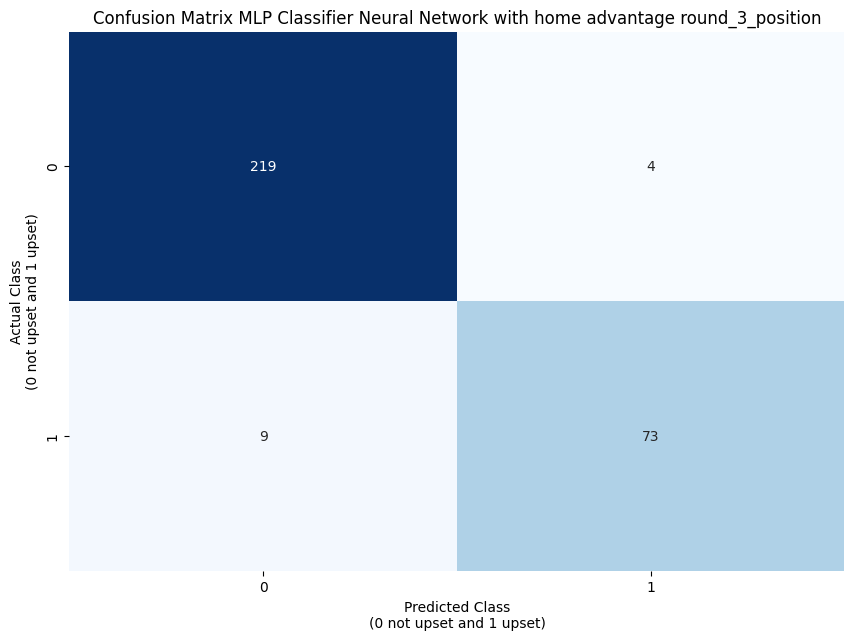

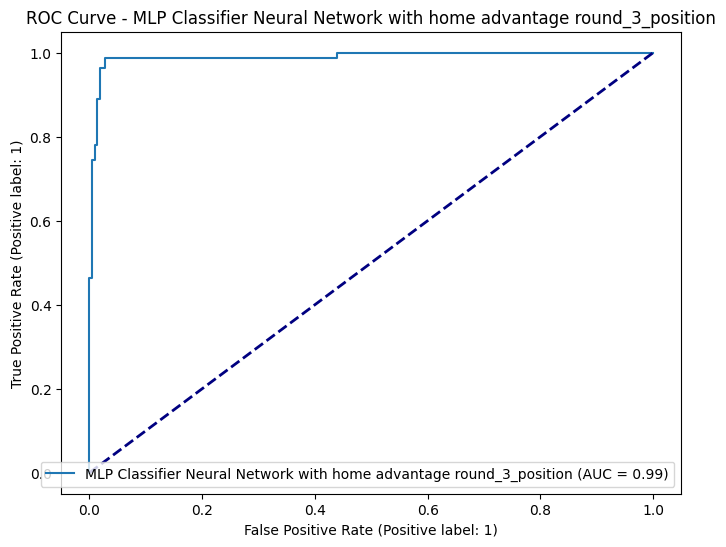

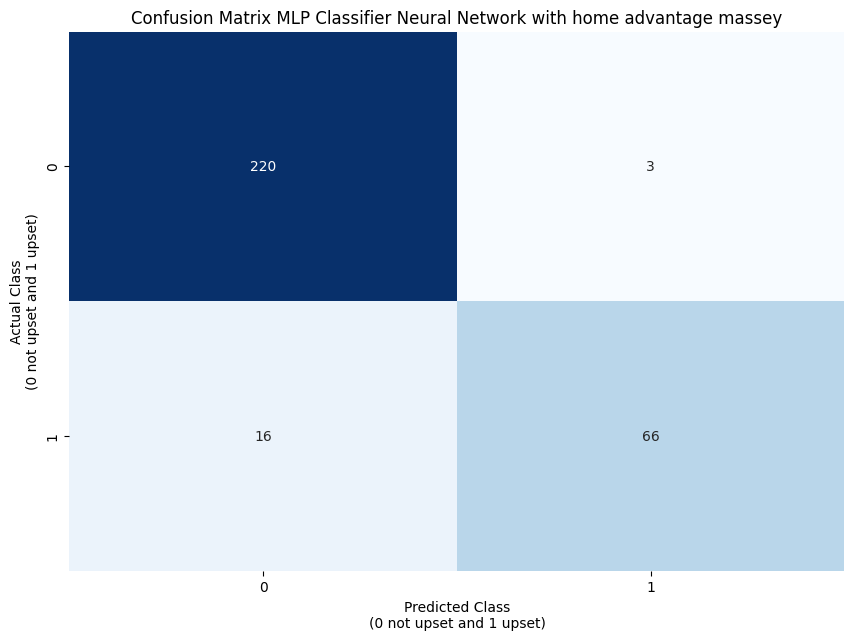

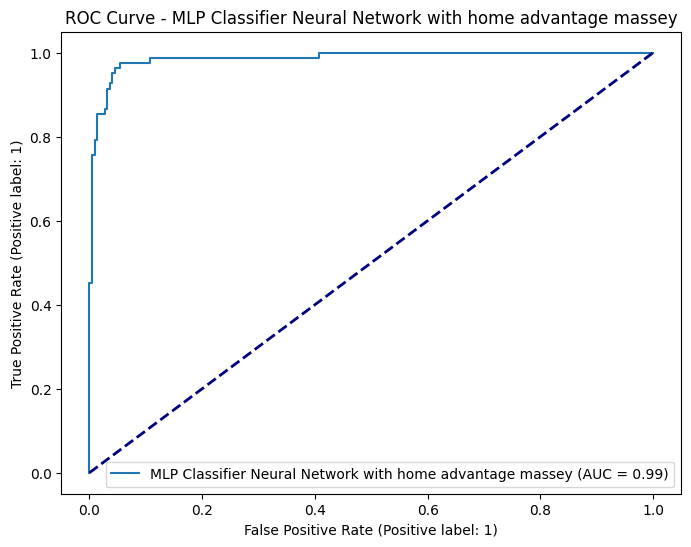

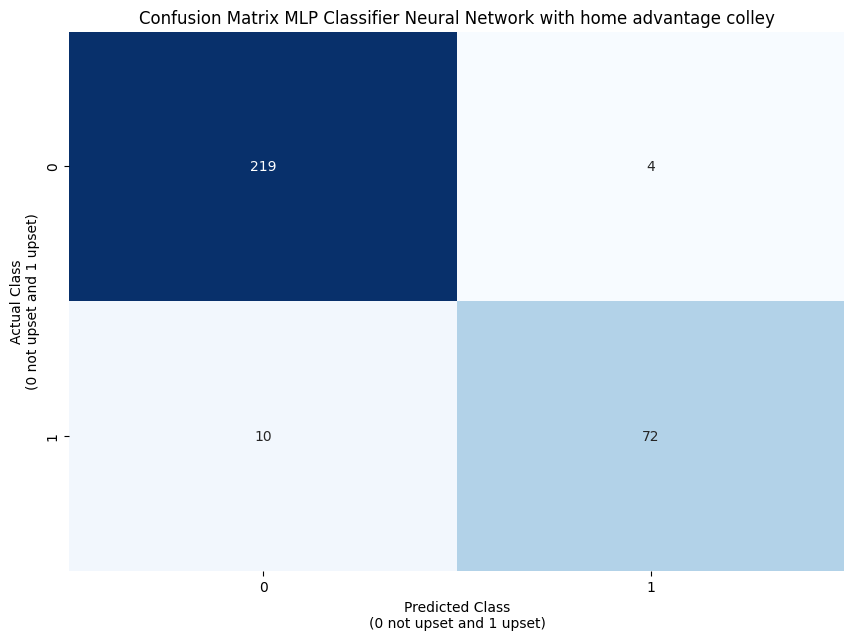

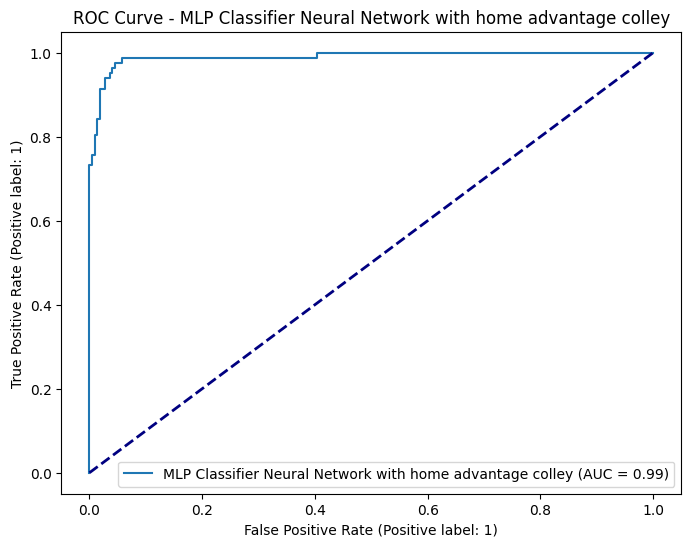

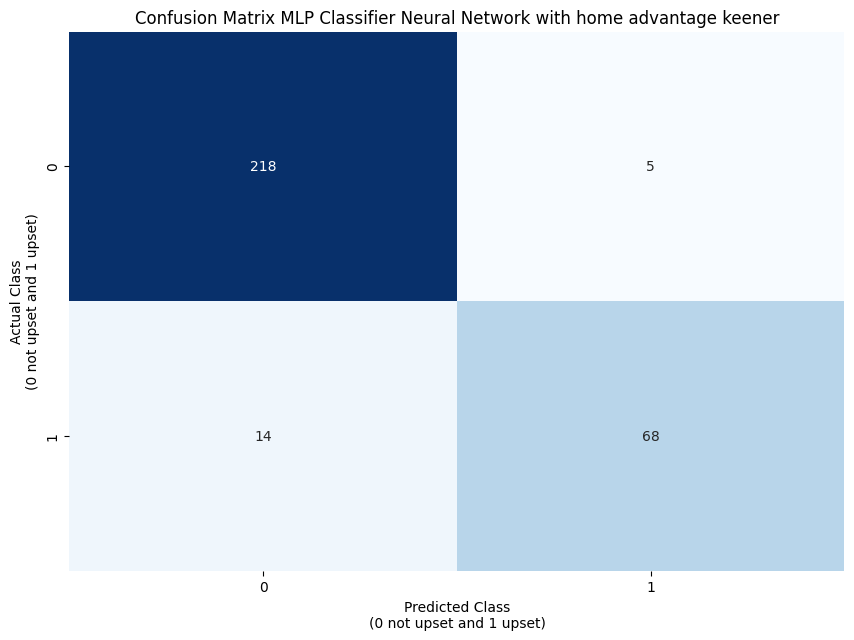

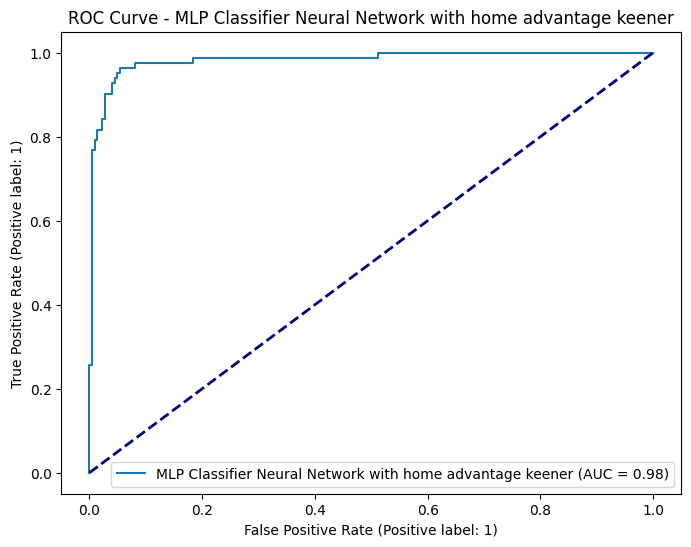

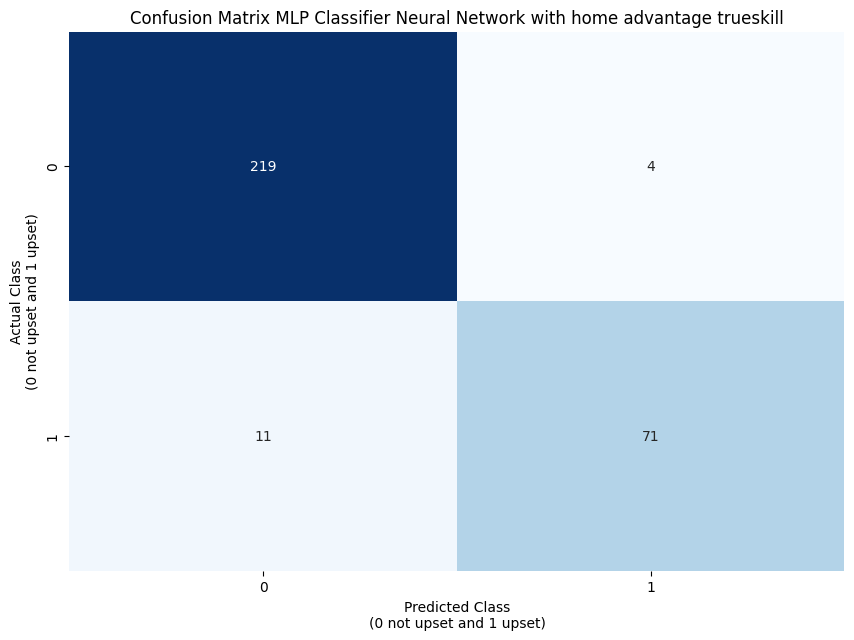

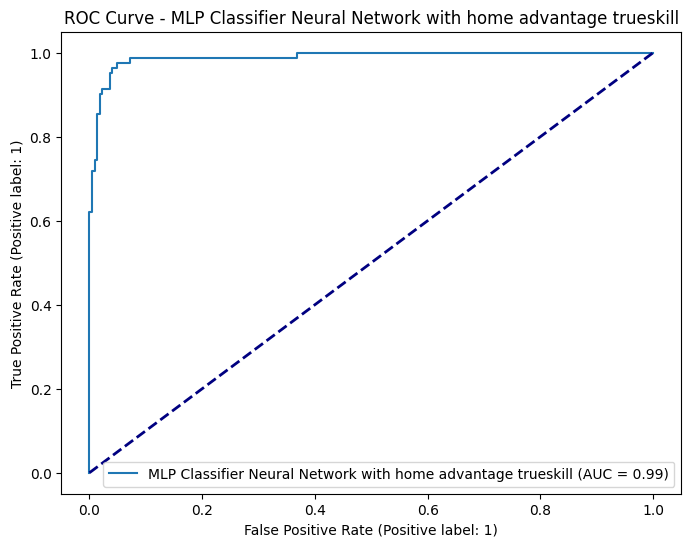

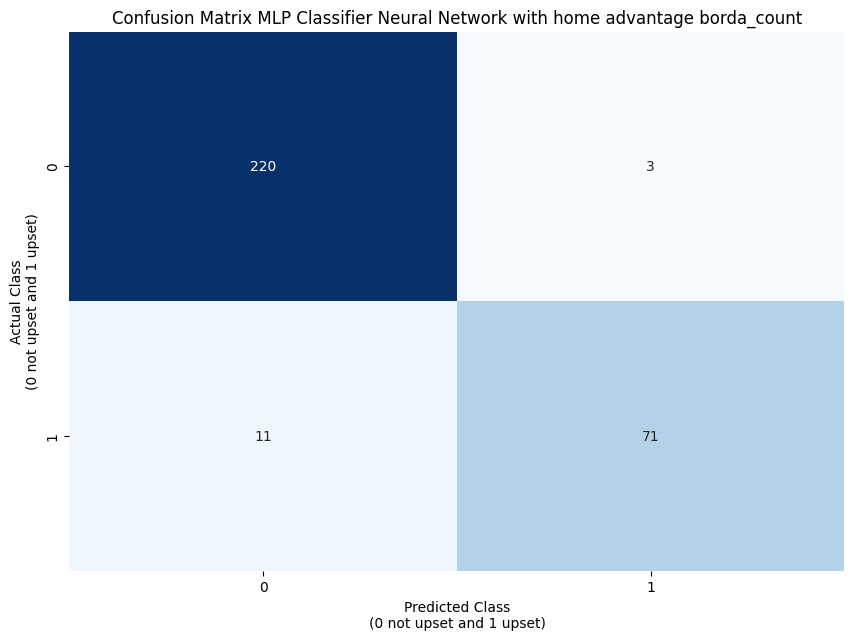

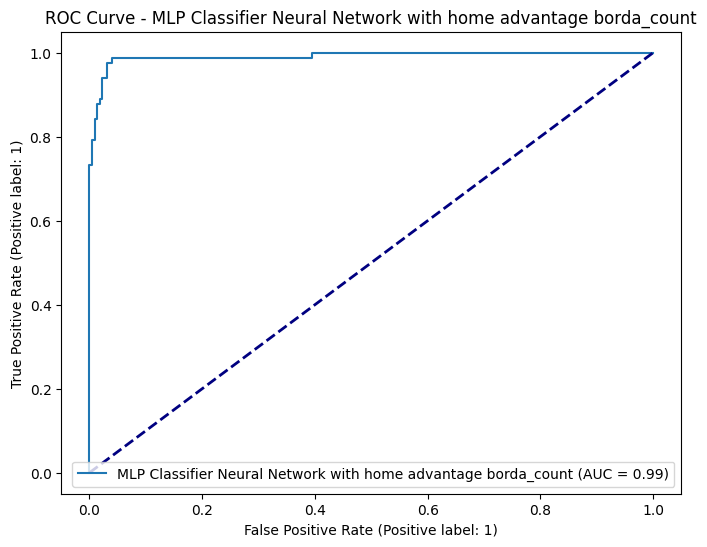

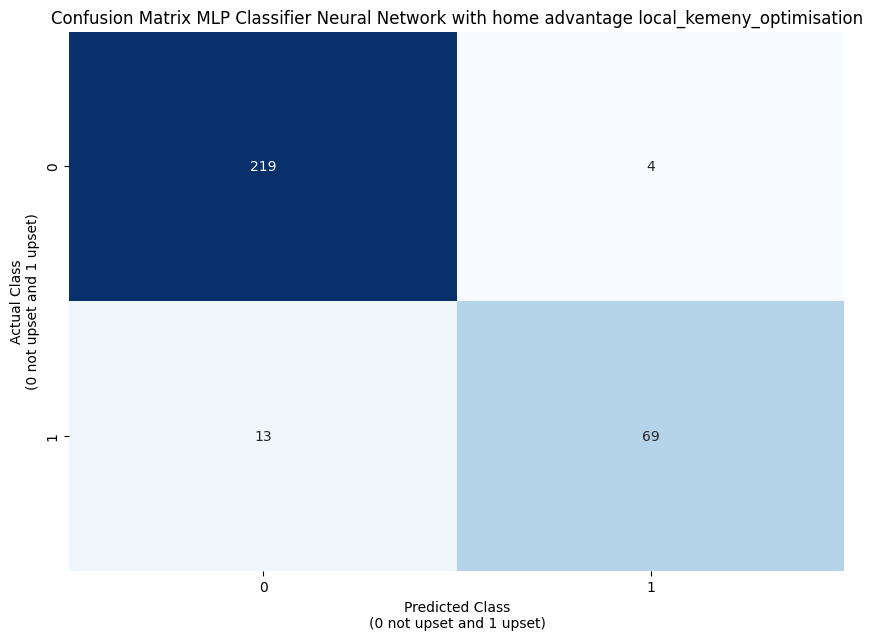

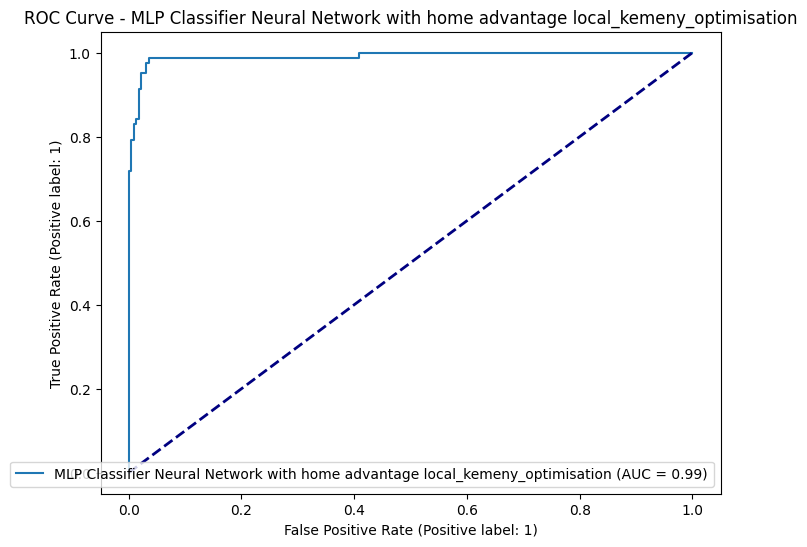

In [ ]:
# MCP Neural Network with home advantage
model_name = "MLP Classifier Neural Network with home advantage"
random_state= 47

# Empty df for consolidating confusion report results
all_results_df_nnh = pd.DataFrame(columns=['metric_id', 'metric'])

# Define the ranking systems
ranking_systems = ['no_ranking','round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]


# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Loop through each ranking system
for ranking in ranking_systems:
    #print(f"\nRunning model for {ranking} ranking system")
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    if ranking == 'no_ranking':
        # Use all base features without ranking
        X = fa_cup_raw_features_df[base_features]
    else:
        # Prepare the feature set for the current ranking system to Include ranking features
        current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
        X = fa_cup_raw_features_df[current_features]

    y = fa_cup_raw_features_df['target_variable']

    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []
    all_y_pred_proba = []  # Store probabilities for ROC

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Add home advantage factor
        X_train, home_advantage_column = add_home_advantage(X_train)
        X_val, _ = add_home_advantage(X_val)

        # Update numeric_features to include the home advantage column
        numeric_features_with_ha = [home_advantage_column] + numeric_features

         # Update preprocessor with current features including home advantage
        if ranking == 'no_ranking':
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)
                ], verbose_feature_names_out=False)

        else:
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features),
                    ('rank', numeric_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
                ], verbose_feature_names_out=False)

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)


        # Create pipeline
        model = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', MLPClassifier(hidden_layer_sizes=(10), max_iter=10000, random_state=random_state))
          ])

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class and ROC curve/AUC Score

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
        all_y_pred_proba.extend(y_pred_proba)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using existing function
    results_df, cm_fig, roc_fig = create_model_results_df(all_y_true, all_y_pred, fold_accuracies,  all_y_pred_proba, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df_nnh = all_results_df_nnh.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df_nnh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_nnh.to_excel("all_nnh_results.xlsx")


In [ ]:
all_results_df_lr = all_results_df_slrh.merge(all_results_df_slr, on=['metric_id', 'metric'], how='outer')
all_results_df_slnn = all_results_df_nn.merge(all_results_df_lr, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_nnh.merge(all_results_df_slnn, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [ ]:
# Load updated Confusion Matrix results to Google Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'lr_ann_model_confusion_matrix_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_results_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')